# Creación del modelo de Car Damages:

En el siguiente notebook se encuentra todo el código para el entrenamiento del modelo de detección de partes de vehículos. Se incluyen explicaciones, pero la explicación detallada se encuentra en la memoria del proyecto.

## Preparación del entorno.

### Instalación de dependencias:

In [3]:
!pip install kagglehub

!pip uninstall opencv-python-headless -y  # Si lo tenías instalado
!pip install opencv-python-headless

!pip install ultralytics
!pip install pyyaml

!apt-get install -y libgl1-mesa-dev
!apt-get install -y libglib2.0-0

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


### Importación de librerías:

In [4]:
import kagglehub
import os
import cv2
import random
import json
import os
import shutil
import pandas as pd
import yaml
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import pickle 

from ultralytics import YOLO

### Definición de funciones:

Función que se usará para pasar a zip las carpetas que contienen los resultados de los tuning, entrenamientos, etc.

In [5]:
def zip_folder(source_folder, output_zip_path):
    if not os.path.exists(source_folder):
        raise FileNotFoundError(f"La carpeta fuente '{source_folder}' no existe.")

    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=source_folder)
                zipf.write(file_path, arcname)

    print(f"Archivo ZIP creado exitosamente: {output_zip_path}")

Función que se usará para mostrar una imagen mediante  Matplotlib, a partir de un array que representa dicha imagen.

In [6]:
def mostrar_imagenes(img):
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    return img

Función que se usará para crear los archivos el fichero '.yaml'.

In [7]:
def crear_archivo(filename, content):

    with open(filename, 'w') as file:
        file.write(content)
    print(f"Contenido guardado en {filename}")

Función que se usará para crear los archivos '.txt' que contienen las etiquetas de los polígonos para el formato de anotaciones de YOLO y para crear el fichero '.yaml'.

In [8]:
def crear_carpeta(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"La carpeta '{folder_path}' ha sido creada.")
    else:
        print(f"La carpeta '{folder_path}' ya existe.")

Función que se usará para crear '.txt' vacios.

In [9]:
def create_empty_txt(file_route):
    try:
        with open(file_route, 'w') as file:
            pass  # No se escribe nada en el archivo para dejarlo vacío
        print(f"Archivo creado exitosamente en: {file_route}")
    except Exception as e:
        print(f"Error al crear el archivo: {e}")

## Pre-procesamiento de datos

El dataset para este modelo ya lo tenemos en este formato:

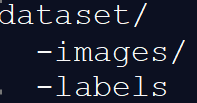

Por lo que se tienen que llevar a cabo los siguientes pasos:

### a) División de imagenes en train y test:

En esta sección, las imágenes se dividen en un 80% para el conjunto de entrenamiento (train) y un 20% para el conjunto de prueba (test).

Primero, se "baraja" el listado de imagenes:

In [10]:
car_damages_images_list = os.listdir('dataset_car_damages/images/')
random.shuffle(car_damages_images_list)

Se calcula el número de imagenes de train:

In [11]:
num_of_images = len(car_damages_images_list)
num_of_images_to_train = num_of_images * 0.8

Se crea un script que cambia el nombre de los ficheros para evitar que haya dos ficheros con el mismo nombre:

In [25]:
import random
import string

num_of_images = len(car_damages_images_list)

new_names = [''.join(random.choices(string.ascii_letters + string.digits, k=15)) for _ in range(num_of_images)]

for num, old_name in enumerate(car_damages_images_list):
    name_no_ext, _, ext = old_name.rpartition('.')
    old_image_name = 'dataset_car_damages/images/' + old_name
    old_label_name = 'dataset_car_damages/labels/' + name_no_ext + '.txt'

    
    new_image_name = 'dataset_car_damages/images/' + 'new_name_' + new_names[num] + '.' + ext
    new_label_name = 'dataset_car_damages/labels/' + 'new_name_' + new_names[num] + '.txt'

    if os.path.exists(old_image_name):
        os.rename(old_image_name, new_image_name)
    else:
        print(f"Archivo no encontrado: {old_image_name}")
    
    # Cambiar el nombre del archivo de etiqueta
    if os.path.exists(old_label_name):
        os.rename(old_label_name, new_label_name)
    else:
        print(f"Archivo no encontrado: {old_label_name}")

Se crean las carpetas de train y de test dentro de las carpetas DATASET DEFINITIVO/ y labels:

In [26]:
crear_carpeta('dataset_car_damages/images/train')
crear_carpeta('dataset_car_damages/images/test')
crear_carpeta('dataset_car_damages/labels/train')
crear_carpeta('dataset_car_damages/labels/test')

La carpeta 'dataset_car_damages/images/train' ha sido creada.
La carpeta 'dataset_car_damages/images/test' ha sido creada.
La carpeta 'dataset_car_damages/labels/train' ha sido creada.
La carpeta 'dataset_car_damages/labels/test' ha sido creada.


Se mueven las imagenes de 'dataset_car_parts/DATASET DEFINITIVO//' a 'dataset_car_parts/DATASET DEFINITIVO//train' y 'dataset_car_parts/DATASET DEFINITIVO//test'.

Se mueven los ficheros '.txt' de 'dataset_car_parts/labels/' a 'dataset_car_parts/labels/train' y 'dataset_car_parts/labels/test'.

In [27]:
files_not_founded = []
car_damages_images_list = os.listdir('dataset_car_damages/images/')
for count, image_name in enumerate(car_damages_images_list):
    if 'test' not in image_name and 'train' not in image_name:
        # Muevo las imagenes y labels a sus carpetas de train:
        if count < num_of_images_to_train:
            try:
                shutil.move('dataset_car_damages/images/' + image_name, 'dataset_car_damages/images/train/' + image_name)
                shutil.move('dataset_car_damages/labels/' + image_name.split('.')[0] + '.txt', 'dataset_car_damages/labels/train/' + image_name.split('.')[0] + '.txt')
            except FileNotFoundError:
                create_empty_txt('dataset_car_damages/labels/train/' + image_name.split('.')[0] + '.txt')
                files_not_founded.append(image_name.split('.')[0])
                
        # Muevo las imagenes y labels a sus carpetas de test:
        else:
            try:
                shutil.move('dataset_car_damages/images/' + image_name, 'dataset_car_damages/images/test/' + image_name)
                shutil.move('dataset_car_damages/labels/' + image_name.split('.')[0] + '.txt', 'dataset_car_damages/labels/test/' + image_name.split('.')[0] + '.txt')
            except FileNotFoundError:
                create_empty_txt('dataset_car_damages/labels/test/' + image_name.split('.')[0] + '.txt')
                files_not_founded.append(image_name.split('.')[0])

### b) Creacion del archivo 'config.yaml'

Se crea el siguiente archivo, que sirve para especificar al modelo las rutas donde están las imágenes, así como el valor asignado a cada una de las etiquetas.

En el siguiente enlace se detalla como tiene que estar informado el fichero 'config.yaml':<br>
https:/docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format

In [12]:
main_route = 'dataset_car_damages'

config_yaml_content = f"""
path: {os.getcwd()}/{main_route}
train: images/train
val: images/test

names:
    0: broken lamp
    1: glass shatter
    2: scratch
    3: dent
    4: tire flat
"""

print(config_yaml_content)

crear_archivo('dataset_car_damages/config.yaml', config_yaml_content)


path: C:\Users\Usuario\Documents\MASTER/dataset_car_damages
train: images/train
val: images/test

names:
    0: broken lamp
    1: glass shatter
    2: scratch
    3: dent
    4: tire flat

Contenido guardado en dataset_car_damages/config.yaml


## Tuning:

Se realiza un ajuste de hiperparámetros (tuning) del modelo para intentar obtener los mejores parámetros posibles para su entrenamiento. Se llevan a cabo 70 iteraciones, con 20 épocas cada una. En el siguiente enlace se explica como se hace: https://docs.ultralytics.com/guides/hyperparameter-tuning/#usage-example

In [ ]:
model = YOLO("yolo11n-seg.yaml")  
model = YOLO("yolo11n-seg.pt") 
model = YOLO("yolo11n-seg.yaml").load("yolo11n-seg.pt")  

model.tune(data='"dataset_car_damages/config.yaml"', epochs=20, iterations=40, optimizer="AdamW", plots=False, save=False, val=False)

Transferred 561/561 items from pretrained weights
Tuner: Initialized Tuner instance with 'tune_dir=runs/segment/tune35'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/40 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Transferred 561/561 items from pretrained weights
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.yaml, data=dataset_car_damages/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=False, save_period=-1, cache=False, device=None, workers=8, project=No

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:02<00:00, 205.26it/s]


train: New cache created: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache


val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<00:00, 179.82it/s]


val: New cache created: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/07 18:32:18 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 18:32:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:32:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(c4a181ce2a7c4bb9af21e0538ee33d94) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train348
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.13G      2.331      4.587      4.175      2.316         46        640: 100%|██████████| 35/35 [00:11<00:00,  3.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G      2.604      4.194      4.027      2.509         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.468      4.107      3.845      2.427         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.347      3.946      3.639      2.369         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.71it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.06G      2.264      3.994      3.613      2.276         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.03G      2.195      3.934       3.38      2.182         33        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.194      3.957      3.371      2.172         55        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.05G      2.095      3.785      3.215      2.093         35        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.177      3.862      3.362       2.14         43        640: 100%|██████████| 35/35 [00:13<00:00,  2.65it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.029      3.701      3.122      2.039         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]


Closing dataloader mosaic


  0%|          | 0/35 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.261      4.129      3.585      2.401         18        640: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.131      4.031      3.377      2.328         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.149      3.972      3.311      2.309         13        640: 100%|██████████| 35/35 [00:09<00:00,  3.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.096      3.971      3.212      2.244         20        640: 100%|██████████| 35/35 [00:08<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.092      3.958      3.116      2.251         21        640: 100%|██████████| 35/35 [00:09<00:00,  3.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.075      3.849      3.049       2.24         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      1.992       3.84      3.004      2.213         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      1.989      3.794      2.908      2.159         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      1.902      3.711      2.787      2.076         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      1.934      3.701      2.865      2.141         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


                   all        142        185      0.716      0.351      0.329      0.195      0.684      0.301      0.273      0.149

20 epochs completed in 0.057 hours.
Optimizer stripped from runs/segment/train348/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train348/weights/best.pt, 6.0MB

Validating runs/segment/train348/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


                   all        142        185      0.716      0.351       0.33      0.195      0.684      0.301      0.273      0.149
           broken lamp         36         36      0.459      0.417      0.385      0.219      0.463      0.417      0.363      0.214
         glass shatter         15         16       0.44      0.562      0.485      0.223      0.273      0.312      0.236      0.108
               scratch         62         75          1          0    0.00822     0.0024          1          0    0.00151   0.000349
                  dent         45         49          1          0     0.0234     0.0102          1          0     0.0173    0.00584
             tire flat          9          9      0.679      0.778      0.746      0.521      0.686      0.778      0.746      0.418
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.0ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00966, momentum=0.94966) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00053), 100 bias(decay=0.0)


2025/01/07 18:36:10 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 18:36:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:36:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(4c5f57eb45ce4471aeb8ba8bf0e1a99d) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train349
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.303      4.567      4.349      2.279         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G      2.664      4.238      4.255      2.541         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.554      4.272      4.143      2.455         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.371      4.067      3.867      2.372         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.06G       2.31      4.031      3.775      2.265         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.01G      2.225       4.04      3.581      2.211         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.261      7.323      3.644      2.234         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.07G       2.13      3.831      3.481      2.112         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.185      3.924      3.531      2.137         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.067      3.747      3.289      2.057         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.228      4.137      3.869      2.397         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.73it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.02G      2.248      4.149      3.693      2.393         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.223      4.054      3.615      2.379         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.212      4.019       3.53       2.34         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.204      4.037      3.425      2.354         21        640: 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.165      4.041      3.342      2.309         27        640: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.104      3.983      3.315      2.298         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.047      3.916      3.231      2.203         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      1.996      3.855      3.123      2.159         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      2.004       3.85      3.106      2.179         18        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


                   all        142        185       0.82      0.283      0.339      0.191      0.808      0.265      0.318      0.157

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train349/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train349/weights/best.pt, 6.0MB

Validating runs/segment/train349/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]


                   all        142        185       0.82      0.283      0.339      0.192      0.807      0.265      0.318      0.157
           broken lamp         36         36      0.607       0.25      0.434      0.267      0.551      0.222      0.412      0.245
         glass shatter         15         16      0.681        0.5      0.519      0.278      0.642      0.438      0.428      0.152
               scratch         62         75          1          0    0.00627    0.00183          1          0    0.00271   0.000896
                  dent         45         49          1          0    0.00755    0.00246          1          0     0.0039    0.00113
             tire flat          9          9       0.81      0.667      0.726       0.41      0.843      0.667      0.742      0.387
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.1ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00966, momentum=0.94532) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/07 18:39:40 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 18:39:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:39:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(aecbacb97a1e435285eb2cbafb9bbeb9) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train350
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.267      4.548      4.983      2.019         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G       2.69      4.125      4.837      2.249         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.514      4.104      4.664      2.112         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.375      3.932      4.372      2.073         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.06G      2.328      3.926      4.324      2.011         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.01G      2.257      3.944      4.102      1.947         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.167      3.945      4.054      1.903         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.08G      2.115      3.789      3.898      1.862         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.159      3.854      3.997      1.872         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.27it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.01G      2.031      3.715      3.683      1.782         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.216      4.015      4.199      2.088         18        640: 100%|██████████| 35/35 [00:10<00:00,  3.47it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.136      3.993      3.996      2.055         19        640: 100%|██████████| 35/35 [00:09<00:00,  3.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.138      3.931      3.956      2.053         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.091      3.907      3.737      1.998         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.27it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.168      3.962      3.772      2.039         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.29it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.075      3.894       3.61      1.969         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.012      3.825      3.566      1.951         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.017      3.753      3.488      1.921         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G       1.91      3.695      3.288       1.85         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.97G      1.967      3.687      3.362        1.9         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


                   all        142        185       0.86      0.328      0.376      0.218       0.86      0.267      0.305      0.161

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train350/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train350/weights/best.pt, 6.0MB

Validating runs/segment/train350/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


                   all        142        185       0.86      0.329      0.376      0.218      0.859      0.267      0.305      0.161
           broken lamp         36         36      0.683       0.48      0.489       0.23      0.561      0.333      0.384        0.2
         glass shatter         15         16      0.616        0.5       0.62      0.328      0.733      0.375       0.38      0.163
               scratch         62         75          1          0    0.00784    0.00208          1          0    0.00366   0.000962
                  dent         45         49          1          0       0.01    0.00336          1          0    0.00661    0.00188
             tire flat          9          9          1      0.663      0.752      0.526          1      0.626      0.752      0.438
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00966, momentum=0.93414) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00046), 100 bias(decay=0.0)


2025/01/07 18:43:10 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:43:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/07 18:43:10 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(0fc921ce3e774538b6475e5fb8d3c4bf) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train351
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.08G      2.479      4.821       3.84      1.957         34        640: 100%|██████████| 35/35 [00:10<00:00,  3.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.04G      2.942      4.921      3.811      2.219         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.54it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.97G      3.107      4.846      3.942      2.328         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.04G      2.876      4.498      3.799      2.213         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.01G      2.815       4.38      3.726      2.116         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.03G      2.719      5.609      3.607      2.122         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.03G       2.69      4.345       3.67      2.106         31        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.06G      2.631      4.328      3.529      2.049         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.03G      2.532      4.333      3.422      2.001         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20         3G      2.481      4.163      3.371      1.914         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.524      4.495      3.658      2.109         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.02G      2.516      4.581      3.567      2.123         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G        2.5      4.495      3.512      2.079         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.29it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.418      4.437      3.419      2.011         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G       2.45      4.391      3.333      2.033         21        640: 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.438      4.402      3.237      2.032         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.336      4.361      3.212       1.98         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G       2.37      4.273      3.172      1.966         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.238      4.277      3.046      1.891         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      2.326      4.264      3.082      1.947         18        640: 100%|██████████| 35/35 [00:07<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


                   all        142        185      0.561      0.294      0.206       0.12       0.61      0.249      0.194      0.113

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train351/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train351/weights/best.pt, 6.0MB

Validating runs/segment/train351/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


                   all        142        185      0.561      0.292      0.206       0.12       0.61      0.249      0.194      0.113
           broken lamp         36         36       0.39      0.306      0.278      0.153      0.529      0.278      0.275      0.149
         glass shatter         15         16      0.211      0.268      0.177     0.0912       0.25      0.188      0.112     0.0569
               scratch         62         75          1          0    0.00142    0.00035          1          0   0.000712   0.000141
                  dent         45         49          1          0     0.0211    0.00933          1          0     0.0173    0.00609
             tire flat          9          9      0.203      0.889      0.555      0.346      0.271      0.778      0.566      0.354
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01183, momentum=0.95471) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00049), 100 bias(decay=0.0)


2025/01/07 18:46:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:46:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/07 18:46:41 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(1b9c12fcfb8e4b2aac56669471a89086) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train352
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.473      4.741      4.436      2.275         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.47it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G      2.755      4.311        4.3      2.492         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.99G      2.664      4.318       4.17      2.408         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.523      4.119      3.924      2.326         36        640: 100%|██████████| 35/35 [00:08<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.451      4.126      3.857      2.205         44        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.03G      2.383      4.148      3.667      2.181         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.77it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.325      4.144       3.66      2.139         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.07G       2.25      3.977      3.496      2.078         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.336      4.068      3.636      2.126         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.194      3.942       3.38      2.049         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.369      4.309      3.831      2.317         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.255      4.291      3.667      2.288         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.42it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G       2.27       4.25      3.576      2.283         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.283      4.193      3.507      2.274         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.264      4.186      3.416      2.273         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G       2.26       4.17      3.452      2.251         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.30it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20         3G      2.172      4.081      3.322      2.192         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.172      4.069      3.232      2.159         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.104      4.037      3.105      2.114         19        640: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      2.106      3.996      3.138      2.143         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


                   all        142        185      0.692      0.291      0.335      0.201      0.914      0.203      0.308      0.163

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train352/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train352/weights/best.pt, 6.0MB

Validating runs/segment/train352/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


                   all        142        185      0.692      0.291      0.335      0.202      0.917      0.202      0.308      0.164
           broken lamp         36         36      0.612      0.176       0.42       0.22      0.975     0.0556      0.388      0.197
         glass shatter         15         16      0.328        0.5      0.426      0.207      0.696      0.289      0.332      0.133
               scratch         62         75          1          0    0.00416    0.00101          1          0    0.00133   0.000299
                  dent         45         49          1          0       0.01     0.0029          1          0    0.00371    0.00126
             tire flat          9          9      0.519      0.778      0.817      0.577      0.915      0.667      0.817      0.486
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01348, momentum=0.92028) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/07 18:50:13 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 18:50:13 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:50:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(dbd4fdf3e4c74ee9a3a50ae8ac16088a) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train353
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      1.873      3.519      4.474      2.237         48        640: 100%|██████████| 35/35 [00:10<00:00,  3.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G       2.19      3.141      4.552       2.62         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.127      3.077      4.539      2.608         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20       3.1G      2.067      3.056      4.456      2.592         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.023      3.052      4.493      2.554         47        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.07G      1.977      3.522      4.385      2.494         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.25it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G       1.94      7.816      4.427      2.453         57        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.05G       1.96      2.941      4.372      2.444         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G       1.92      3.023      4.362      2.405         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.77it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.04G      1.881      2.933      4.258      2.342         49        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      1.903      3.139      4.548      2.451         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      1.859      3.138      4.321      2.398         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.32it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      1.888      3.115      4.185      2.361         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G       1.86      3.104      4.151      2.332         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G        1.8      3.085      4.029      2.314         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      1.797      3.076      3.959       2.29         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      1.763      3.077      3.934      2.266         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.42it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      1.759      3.031      3.887      2.223         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      1.739      3.033      3.748      2.191         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      1.753      2.997      3.797      2.238         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


                   all        142        185        0.6      0.193      0.168     0.0704      0.549      0.157      0.126     0.0436

20 epochs completed in 0.052 hours.
Optimizer stripped from runs/segment/train353/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train353/weights/best.pt, 6.0MB

Validating runs/segment/train353/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


                   all        142        185      0.593      0.193      0.168     0.0704      0.548      0.157      0.127     0.0436
           broken lamp         36         36      0.197      0.333      0.154     0.0597      0.179      0.278      0.139     0.0474
         glass shatter         15         16       0.45      0.188       0.23     0.0855      0.189     0.0625     0.0468     0.0196
               scratch         62         75          1          0    0.00261   0.000601          1          0   0.000835   0.000123
                  dent         45         49          1          0    0.00183   0.000387          1          0   0.000959   0.000217
             tire flat          9          9      0.318      0.444      0.454      0.206      0.372      0.444      0.445      0.151
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01019, momentum=0.94893) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00052), 100 bias(decay=0.0)


2025/01/07 18:53:43 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 18:53:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:53:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(584ee5c207394d518eec4e57b62c1c05) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train354
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.465      4.835      4.984      2.338         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.44it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G      2.755      4.493      4.752      2.515         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.638      4.398      4.616      2.406         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.27it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.532      4.216      4.281      2.353         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.434      4.191       4.28      2.255         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.01G      2.354      4.192      4.012      2.214         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.308       4.21      4.057      2.193         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.08G      2.227       4.01      3.864       2.11         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.25it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.06G      2.325      4.107      4.011       2.16         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.156      3.921      3.675      2.035         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.362      4.435      4.328      2.407         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.52it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.273      4.291      4.093       2.36         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G       2.24      4.218      3.979      2.376         13        640: 100%|██████████| 35/35 [00:09<00:00,  3.71it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G       2.25      4.179       3.85      2.317         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.251       4.21      3.849       2.33         21        640: 100%|██████████| 35/35 [00:07<00:00,  4.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.184      4.131      3.753      2.253         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.114      4.063      3.648      2.249         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.42it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.124      4.013      3.542      2.194         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.032       3.95      3.387      2.119         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.97G      2.066       3.98      3.431      2.157         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


                   all        142        185      0.723      0.362       0.35      0.209      0.699      0.318      0.305      0.169

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train354/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train354/weights/best.pt, 6.0MB

Validating runs/segment/train354/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


                   all        142        185      0.723      0.362       0.35      0.209      0.698      0.318      0.305      0.169
           broken lamp         36         36      0.411        0.5       0.45      0.268      0.432        0.5      0.439       0.28
         glass shatter         15         16      0.485      0.531      0.514      0.189      0.326      0.312      0.306     0.0938
               scratch         62         75          1          0     0.0104    0.00291          1          0    0.00566     0.0011
                  dent         45         49          1          0    0.00559    0.00193          1          0    0.00427    0.00113
             tire flat          9          9      0.717      0.778      0.771      0.581      0.732      0.778      0.771      0.467
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 1.0ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01239, momentum=0.9599) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00049), 100 bias(decay=0.0)


2025/01/07 18:57:13 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 18:57:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/07 18:57:13 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(91d24bd6169f405f8d387453e009fb03) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train355
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.469      4.739      4.531       2.33         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.31it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.458      4.052      3.962      2.347         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.438      4.081      3.984      2.276         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.02G      2.313       4.01      3.738      2.217         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.279       4.04      3.734       2.21         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.07G      2.212      3.929       3.59      2.139         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.298      4.015      3.665      2.142         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.138      3.805      3.423      2.031         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.332      4.219      3.971       2.36         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.219      4.169      3.737      2.283         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.02G      2.245      4.106      3.651      2.312         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20         3G      2.237      4.112      3.572      2.311         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.209      4.078      3.473      2.284         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.99G      2.182      4.043      3.374      2.247         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.117      3.967      3.314      2.203         17        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.144      3.918      3.271      2.176         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.067      3.906      3.158       2.13         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G       2.09      3.887      3.186      2.167         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


                   all        142        185      0.712      0.307      0.309      0.166      0.654      0.316      0.267      0.136

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train355/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train355/weights/best.pt, 6.0MB

Validating runs/segment/train355/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


                   all        142        185       0.71      0.307      0.309      0.166      0.656       0.32      0.267      0.136
           broken lamp         36         36      0.415      0.444      0.329      0.147      0.304      0.462      0.296      0.135
         glass shatter         15         16      0.428      0.312       0.37      0.194      0.324      0.359      0.202     0.0886
               scratch         62         75          1          0    0.00715    0.00206          1          0     0.0023    0.00048
                  dent         45         49          1          0    0.00601    0.00219          1          0    0.00241   0.000522
             tire flat          9          9      0.706      0.778      0.835      0.483       0.65      0.778      0.835      0.454
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01353, momentum=0.98) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00032), 100 bias(decay=0.0)


2025/01/07 19:00:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:00:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/07 19:00:46 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(37e0758eae2847e89e4b3db8e6e8a8ef) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train356
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.08G      2.714      5.264       5.97      2.441         33        640: 100%|██████████| 35/35 [00:10<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.06G      3.232       5.15      6.023      2.857         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.06G      3.093      4.783      5.979      2.744         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.03G       2.92      4.595      5.799       2.67         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20         3G      2.954      4.524      5.727      2.659         45        640: 100%|██████████| 35/35 [00:08<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.06G      2.864      5.095      5.498      2.582         31        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.06G      2.757      4.402      5.384      2.521         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.03G      2.746      4.395      5.388      2.467         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20         3G      2.733      4.438      5.311      2.487         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.97G      2.694      4.445      5.275      2.414         24        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.683      4.659      5.506      2.618         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.612      4.642      5.373      2.574         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.598      4.601      5.271      2.562         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.576      4.598      5.266      2.513         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.29it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.581      4.588      5.125      2.524         21        640: 100%|██████████| 35/35 [00:07<00:00,  4.44it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.564      4.579      5.066      2.494         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20         3G      2.514      4.551      5.003      2.454         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G       2.52      4.498      4.982      2.454         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.438      4.521      4.823      2.384         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G        2.5      4.469      4.892      2.443         18        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


                   all        142        185      0.571      0.221      0.159     0.0676      0.631      0.163       0.15     0.0599

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train356/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train356/weights/best.pt, 6.0MB

Validating runs/segment/train356/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


                   all        142        185      0.629      0.163      0.158     0.0685      0.629      0.163      0.149     0.0605
           broken lamp         36         36      0.397      0.167      0.211     0.0984      0.397      0.167      0.201     0.0853
         glass shatter         15         16      0.469      0.312      0.332       0.12      0.469      0.312        0.3      0.116
               scratch         62         75          1          0    0.00182   0.000356          1          0   0.000498   6.76e-05
                  dent         45         49          1          0    0.00143   0.000337          1          0   0.000616   0.000126
             tire flat          9          9       0.28      0.333      0.245      0.123       0.28      0.333      0.243      0.101
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.0ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00966, momentum=0.91781) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00053), 100 bias(decay=0.0)


2025/01/07 19:04:16 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 19:04:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:04:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(9d43def3068c4ceb87e7b4cacb1c2437) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train357
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.414      4.721      4.773      2.271         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G      2.815      4.402       4.69      2.518         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.769      4.285      4.588      2.453         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G       2.58      5.216      4.345      2.373         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.391      4.782      4.232      2.246         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.01G      2.408      4.332      4.092      2.276         31        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.309      4.135      4.081      2.186         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.08G      2.259      3.971      3.902      2.133         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.293      4.027      4.025      2.116         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.01G      2.156      3.875      3.707      2.024         49        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.316      4.237      4.135      2.382         18        640: 100%|██████████| 35/35 [00:10<00:00,  3.43it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.264      4.192      4.058       2.35         19        640: 100%|██████████| 35/35 [00:09<00:00,  3.83it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.315      4.184      4.021      2.348         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.252      4.124      3.864      2.287         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.266      4.126      3.773      2.315         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.30it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.222      4.073      3.668      2.279         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.102      4.025      3.607      2.214         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.151      4.023      3.514      2.181         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.32it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.032      3.946      3.366      2.083         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      2.095      3.958      3.404      2.155         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


                   all        142        185      0.715      0.284      0.328      0.203      0.741      0.212      0.261      0.152

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train357/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train357/weights/best.pt, 6.0MB

Validating runs/segment/train357/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


                   all        142        185      0.715      0.283      0.327      0.203      0.737      0.209      0.261      0.152
           broken lamp         36         36      0.514      0.417      0.434      0.259      0.558      0.351      0.394      0.232
         glass shatter         15         16      0.477      0.375       0.41      0.165      0.266      0.137      0.124     0.0635
               scratch         62         75          1          0     0.0046     0.0013          1          0    0.00221   0.000537
                  dent         45         49          1          0    0.00787    0.00251          1          0    0.00372    0.00115
             tire flat          9          9      0.582      0.622      0.781      0.586      0.862      0.556      0.781      0.464
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.0097, momentum=0.98) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00053), 100 bias(decay=0.0)


2025/01/07 19:07:47 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 19:07:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:07:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(ed1981634fe34732bba0514fce0b8299) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train358
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.376      4.662      5.055      2.511         46        640: 100%|██████████| 35/35 [00:11<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.99G      2.594      4.193      4.819       2.62         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.469      4.136       4.61      2.558         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.346      4.018      4.328      2.492         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.341      3.986      4.208      2.437         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.01G      2.231      3.977       4.03      2.357         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.157       3.98      4.065      2.318         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.08G      2.096      3.816      3.871       2.25         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.06G      2.222      3.917       4.06      2.328         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.084      3.755      3.846      2.225         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.293      4.119      4.446      2.604         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.208      4.128      4.228      2.556         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.30it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.197      4.056      4.141       2.51         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.203      4.039      4.072      2.481         20        640: 100%|██████████| 35/35 [00:09<00:00,  3.77it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.187      4.032      4.032      2.487         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.03it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.178      3.983      3.952      2.489         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.087       3.99      3.922      2.416         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.108       3.89      3.819      2.381         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.032      3.879      3.702      2.341         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.97G      2.074      3.868      3.721      2.396         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


                   all        142        185      0.813      0.253      0.324      0.193      0.739      0.228      0.263       0.14

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train358/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train358/weights/best.pt, 6.0MB

Validating runs/segment/train358/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


                   all        142        185      0.796      0.253      0.325      0.193      0.735      0.228      0.264      0.139
           broken lamp         36         36       0.53      0.333      0.408      0.246       0.52      0.333      0.399      0.208
         glass shatter         15         16      0.593      0.375      0.499      0.274      0.392       0.25      0.206     0.0886
               scratch         62         75          1          0    0.00343    0.00102          1          0    0.00134   0.000316
                  dent         45         49          1          0     0.0108    0.00378          1          0    0.00933    0.00203
             tire flat          9          9      0.857      0.556      0.703      0.439      0.763      0.556      0.703      0.399
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 0.8ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01183, momentum=0.94819) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00047), 100 bias(decay=0.0)


2025/01/07 19:11:20 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 19:11:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:11:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(e26904aa0876444f9e080b0e84e5c2e9) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train359
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.457      4.767       3.78      2.292         44        640: 100%|██████████| 35/35 [00:10<00:00,  3.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G      2.844      4.314      3.688      2.557         41        640: 100%|██████████| 35/35 [00:08<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.99G      2.717      4.286      3.647      2.438         48        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.565      4.218      3.466      2.379         35        640: 100%|██████████| 35/35 [00:09<00:00,  3.52it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.466      4.194      3.388        2.3         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.02G      2.385      4.159       3.25      2.253         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.344      4.185      3.297      2.221         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.07G      2.221      3.973      3.094      2.104         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.351       4.14      3.267      2.166         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20         3G      2.181      3.953      3.009      2.044         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.363      4.291      3.423      2.383         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.308      4.289      3.281      2.363         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.02G      2.324      4.239      3.221      2.346         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20         3G      2.236      4.175      3.119      2.278         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.243      4.148      3.092      2.278         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.32it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.99G      2.195      4.167       3.05      2.245         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.208      4.129      3.019      2.245         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.187      4.076      2.946      2.203         19        640: 100%|██████████| 35/35 [00:09<00:00,  3.83it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.085      4.032      2.857      2.136         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      2.088      4.052      2.887      2.158         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


                   all        142        185      0.646      0.264      0.251      0.146      0.611      0.251      0.206      0.106

20 epochs completed in 0.054 hours.
Optimizer stripped from runs/segment/train359/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train359/weights/best.pt, 6.0MB

Validating runs/segment/train359/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


                   all        142        185      0.628      0.294      0.255      0.148      0.602      0.251      0.207      0.106
           broken lamp         36         36      0.289      0.306      0.253       0.13       0.27      0.278      0.207      0.112
         glass shatter         15         16      0.361        0.5      0.363      0.175       0.24      0.312      0.174     0.0644
               scratch         62         75          1          0    0.00354   0.000938          1          0    0.00155   0.000408
                  dent         45         49          1          0    0.00284   0.000995          1          0    0.00228    0.00065
             tire flat          9          9      0.489      0.667       0.65      0.432      0.498      0.667       0.65      0.354
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 0.9ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01031, momentum=0.94664) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00053), 100 bias(decay=0.0)


2025/01/07 19:14:54 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 19:14:54 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:14:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(a75bdb8caa464cc2ad46c4206aee3721) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train360
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.368      4.554       4.97      2.308         47        640: 100%|██████████| 35/35 [00:10<00:00,  3.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.06G       2.63      4.291      4.946      2.522         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.03G      2.598      4.352      4.692      2.475         66        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.06G      2.452      4.174      4.499      2.389         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.02G      2.377      4.073      4.424      2.299         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.05G      2.351       4.03      4.322      2.314         39        640: 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.04G      2.238      4.003      4.139      2.201         48        640: 100%|██████████| 35/35 [00:08<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.04G      2.242      3.998      4.073      2.156         30        640: 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.03G      2.242      4.028      4.078      2.192         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.99G      2.149      3.869      3.901      2.074         51        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.347      4.221      4.377      2.434         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.275      4.132       4.22      2.391         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.38it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.292      4.105      4.166      2.402         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.218      4.065      4.061      2.321         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.189      4.075      3.897       2.31         21        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.199      4.041      3.816      2.286         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.089      3.984      3.742      2.236         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.075      3.921      3.692      2.183         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.38it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.027      3.899       3.55      2.133         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G       2.06      3.894      3.569      2.189         18        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


                   all        142        185      0.754       0.32       0.35      0.202      0.727      0.295      0.306      0.154

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train360/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train360/weights/best.pt, 6.0MB

Validating runs/segment/train360/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


                   all        142        185      0.753      0.321       0.35      0.202      0.727      0.295      0.306      0.154
           broken lamp         36         36      0.556      0.389      0.367      0.208      0.559      0.387      0.344      0.164
         glass shatter         15         16      0.486      0.438      0.509      0.221      0.351      0.312      0.321     0.0947
               scratch         62         75          1          0    0.00829    0.00157          1          0    0.00205   0.000468
                  dent         45         49          1          0     0.0143    0.00658          1          0     0.0128    0.00347
             tire flat          9          9      0.725      0.778       0.85      0.572      0.727      0.778       0.85      0.508
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.0ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01183, momentum=0.9621) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00049), 100 bias(decay=0.0)


2025/01/07 19:18:27 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 19:18:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:18:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(2d1528ada1194488a69eae9565021b78) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train361
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G      2.687      5.071      4.579      2.525         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20         3G      2.956      4.462      4.482      2.705         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20         3G      2.741      4.433      4.318      2.579         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.07G      2.664      4.304       4.14      2.554         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.03G      2.572      4.341      4.031      2.414         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.01G      2.552      4.247       3.92      2.417         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.07G      2.485      4.249      3.913      2.378         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.08G      2.414      4.092       3.76      2.312         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.30it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.07G      2.456      4.233      3.886      2.326         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.02G      2.342      4.043      3.668      2.243         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]


Closing dataloader mosaic


  0%|          | 0/35 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G       2.48      4.406      4.121      2.545         18        640: 100%|██████████| 35/35 [00:11<00:00,  3.11it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.423      4.406      3.944      2.499         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.365       4.35      3.872      2.461         13        640: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.327      4.334        3.8      2.409         20        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.344      4.322      3.677      2.434         21        640: 100%|██████████| 35/35 [00:07<00:00,  4.38it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.299      4.308      3.596      2.394         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.236      4.176      3.567      2.393         17        640: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.266      4.184      3.507      2.381         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.47it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G       2.18      4.169      3.388      2.297         19        640: 100%|██████████| 35/35 [00:07<00:00,  4.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.96G      2.195      4.128      3.394      2.344         18        640: 100%|██████████| 35/35 [00:07<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


                   all        142        185      0.649      0.276      0.259      0.172      0.645      0.271      0.239      0.132

20 epochs completed in 0.053 hours.
Optimizer stripped from runs/segment/train361/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train361/weights/best.pt, 6.0MB

Validating runs/segment/train361/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


                   all        142        185      0.649      0.276      0.258      0.171      0.646      0.271      0.239      0.132
           broken lamp         36         36       0.52      0.306      0.337      0.172      0.483      0.278      0.302      0.144
         glass shatter         15         16      0.285      0.188      0.166     0.0894      0.298      0.188      0.108     0.0495
               scratch         62         75          1          0    0.00351    0.00085          1          0    0.00122   0.000288
                  dent         45         49          1          0    0.00625    0.00186          1          0    0.00358   0.000902
             tire flat          9          9      0.443      0.889       0.78      0.593      0.447      0.889       0.78      0.466
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.0ms postprocess per image
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
💡 Learn more at https://docs.ult

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01078, momentum=0.87359) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00063), 100 bias(decay=0.0)


2025/01/07 19:21:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:21:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/07 19:21:57 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(894b68354297429fa17bc70d38cf0b77) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train362
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.04G      2.341      4.487      4.882      2.246         42        640: 100%|██████████| 35/35 [00:11<00:00,  3.03it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.03G      2.688      4.215      4.745      2.544         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.05G       2.76      4.131      4.882      2.618         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.01G      2.617      4.098      4.715      2.507         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.08G      2.581       4.97      4.686      2.438         50        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.06G      2.496      4.082      4.478      2.317         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.01G      2.409       3.95      4.399      2.272         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.05G      2.373      3.942      4.275      2.236         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.05G      2.288      3.872      4.129      2.161         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20         3G      2.179      3.802      4.125      2.104         52        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.03G      2.326       4.11      4.468      2.407         18        640: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.03G      2.284       4.05       4.23      2.387         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.03G      2.296      4.036        4.2      2.384         13        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.99G      2.267      4.006      4.093      2.337         20        640: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20         3G      2.237      3.993      3.957      2.306         21        640: 100%|██████████| 35/35 [00:09<00:00,  3.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20         3G      2.173      3.991      3.849      2.242         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.28it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.99G      2.098      3.971      3.741      2.194         17        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.03G      2.077      3.889      3.679      2.166         19        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20         3G      2.035      3.882      3.537      2.116         22        640:  86%|████████▌ | 30/35 [00:07<00:01,  4.21it/s]
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ultralytics/cfg/__init__.py", line 973, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ultralytics/engine/model.py", line 806, in train
    self.trainer.train()
  File "/opt/conda/lib/python3.11/site-packages/ultralytics/engine/trainer.py", line 207, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.11/site-packages/ultralytics/engine/trainer.py", line 380, in _do_train
    self.loss, self.loss_items = self.model(batch)
                                 ^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/nn/modul

KeyboardInterrupt: 

In [15]:
zip_folder('/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/runs/segment/tune35', '/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/tune35.zip')

Archivo ZIP creado exitosamente: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/tune35.zip


El siguiente fichero '.yaml' contiene los mejores hiperparámetros. Se guardan estos valores en una variable para posteriormente usarlos en el entrenamiento.

In [16]:
hyperparameters_path = "runs/segment/tune35/best_hyperparameters.yaml"

with open(hyperparameters_path, "r") as file:
    best_hyperparameters = yaml.safe_load(file)
print(best_hyperparameters)

{'lr0': 0.00966, 'lrf': 0.01009, 'momentum': 0.94532, 'weight_decay': 0.0005, 'warmup_epochs': 2.63088, 'warmup_momentum': 0.75211, 'box': 7.43346, 'cls': 0.60252, 'dfl': 1.30928, 'hsv_h': 0.01385, 'hsv_s': 0.67314, 'hsv_v': 0.38628, 'degrees': 0.0, 'translate': 0.09708, 'scale': 0.49239, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.48874, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}


Ahora, con estos parametros, se entrena el modelo:

## Entrenamiento:

Se entrena el modelo con 500 épocas, un tamaño de imagen de 640 píxeles y un valor de paciencia de 15, usando los mejores hiperparámetros obtenidos. El valor de paciencia de 15 indica que si no se observa una mejora en el rendimiento durante 15 épocas consecutivas, el entrenamiento se detendrá de forma anticipada.

In [17]:
model = YOLO("yolo11n-seg.yaml")
model = YOLO("yolo11n-seg.pt")
model = YOLO("yolo11n-seg.yaml").load("yolo11n-seg.pt")

results = model.train(data='dataset_car_damages/config.yaml', epochs=500, imgsz=640, **best_hyperparameters)

Transferred 561/561 items from pretrained weights
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.yaml, data=dataset_car_damages/config.yaml, epochs=500, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train363, exist_ok=False, pretrained=yolo11n-seg.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/train.cache... 558 images, 57 backgrounds, 0 corrupt: 100%|██████████| 558/558 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]


Plotting labels to runs/segment/train363/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00966' and 'momentum=0.94532' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/07 19:27:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 19:27:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/07 19:27:17 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 19:27:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2025/01/07 19:27:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(ea3d38510f57474c8e4868e3d2cb6945) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train363
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/500       3.1G      1.427      3.844      4.798      1.469         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        142        185    0.00762      0.625      0.198     0.0993     0.0059      0.578      0.176     0.0855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/500         3G       1.59      3.188      4.143      1.462         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


                   all        142        185      0.816      0.165      0.316       0.18      0.806       0.16      0.301      0.131

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/500      3.01G      1.636      3.211      3.829      1.495         48        640: 100%|██████████| 35/35 [00:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


                   all        142        185      0.778      0.248      0.283      0.151      0.785      0.254      0.275      0.135

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/500      3.07G      1.612      3.051      3.472      1.489         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


                   all        142        185      0.838      0.215      0.278      0.145      0.825       0.21      0.254      0.125

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/500      3.04G      1.616      3.028      3.395        1.5         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


                   all        142        185      0.338      0.367      0.301      0.141       0.25      0.273      0.185     0.0688

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/500      3.04G      1.545      2.998      3.116      1.446         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


                   all        142        185      0.381      0.137      0.113     0.0392      0.382      0.187      0.121     0.0429

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/500      3.08G      1.553      2.933      3.015      1.432         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


                   all        142        185       0.33      0.361      0.375      0.217      0.615      0.286      0.366      0.201

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/500      3.09G      1.474      2.852      2.835       1.39         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


                   all        142        185      0.812      0.299      0.326       0.16      0.794      0.286      0.299      0.166

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/500      3.07G      1.588      2.997      2.988      1.455         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


                   all        142        185      0.433       0.32       0.39      0.241      0.433       0.32      0.351        0.2

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/500      3.02G      1.494      2.838      2.706      1.403         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        142        185      0.481      0.418      0.419       0.22      0.451      0.369      0.349       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/500      3.08G      1.452      2.721      2.569      1.386         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


                   all        142        185      0.404      0.453      0.429      0.256      0.387      0.401      0.378      0.208

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/500      3.03G      1.434      2.751      2.572      1.357         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142        185      0.658      0.399      0.417      0.272      0.637      0.374      0.394       0.25



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/500      3.05G      1.388      2.648      2.379      1.339         45        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        142        185       0.52      0.484      0.473      0.293      0.437      0.455      0.428      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/500      3.04G      1.435      2.737      2.427      1.371         48        640: 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


                   all        142        185      0.521      0.428      0.433      0.273      0.739      0.366      0.383       0.22

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/500      3.09G      1.456      2.738       2.43      1.356         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


                   all        142        185      0.391      0.524      0.444      0.286      0.574      0.363      0.431      0.257

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/500      3.05G      1.366      2.624       2.29      1.312         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


                   all        142        185      0.597      0.479      0.533      0.294      0.579      0.463      0.485      0.284

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/500      3.11G      1.374      2.573      2.255      1.292         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        142        185      0.587      0.428      0.414      0.239      0.458      0.437      0.404      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/500      3.04G      1.329      2.557      2.183      1.274         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


                   all        142        185      0.669      0.464      0.512       0.33      0.913      0.383      0.479      0.293

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/500      3.03G      1.378      2.597      2.189      1.296         40        640: 100%|██████████| 35/35 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142        185      0.669      0.355      0.452      0.273      0.646      0.343        0.4      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/500      3.08G      1.356      2.613      2.179      1.288         31        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


                   all        142        185      0.815      0.434      0.478      0.294      0.775      0.376      0.407      0.261

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/500      3.02G      1.362      2.647      2.178      1.301         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

                   all        142        185      0.632      0.478      0.558      0.362      0.521      0.462      0.484      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/500      3.04G      1.308      2.497      1.994      1.274         47        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


                   all        142        185      0.438      0.447      0.464      0.292      0.719      0.372      0.407      0.241

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/500      3.02G      1.325      2.491      2.004      1.252         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all        142        185       0.65      0.436      0.515      0.345      0.612      0.418      0.464      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/500      3.02G      1.295      2.476       2.02      1.255         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        142        185      0.841      0.393      0.514      0.318      0.811      0.369      0.457      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/500      3.08G      1.268       2.36      1.906       1.23         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        142        185      0.569      0.502      0.523      0.338      0.497      0.466       0.46      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/500      3.04G      1.276      2.436      1.861      1.227         26        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        142        185      0.648       0.49      0.549      0.346      0.499      0.431      0.465      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/500      3.02G      1.255      2.408      1.858      1.216         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        142        185       0.52      0.563      0.538      0.336      0.496      0.535      0.509      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/500      3.02G      1.242       2.33      1.819      1.208         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        142        185      0.584      0.451      0.475      0.303      0.534      0.406      0.433      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/500      3.01G       1.27      2.355      1.899      1.216         42        640: 100%|██████████| 35/35 [00:10<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        142        185      0.731      0.466      0.494      0.295      0.692       0.41      0.419      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/500      3.05G      1.265       2.37      1.797      1.216         56        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        142        185      0.569       0.46      0.494      0.286       0.53      0.409      0.413      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/500      3.03G      1.268      2.413      1.811      1.201         37        640: 100%|██████████| 35/35 [00:08<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        142        185      0.512      0.462      0.492      0.319      0.469      0.429      0.423      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/500         3G      1.234      2.317       1.77      1.191         52        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        142        185      0.595      0.482       0.54      0.345       0.54      0.465       0.49       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/500      3.03G      1.232       2.29      1.721      1.186         40        640: 100%|██████████| 35/35 [00:10<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        142        185        0.6      0.487      0.532      0.342      0.429      0.517       0.47       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/500      3.04G      1.201       2.29      1.684      1.171         47        640: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

                   all        142        185      0.569      0.487      0.544      0.364      0.541      0.467        0.5      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/500      3.02G       1.25      2.308      1.723      1.194         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        142        185      0.542      0.569      0.575      0.384      0.467      0.506      0.491      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/500         3G      1.182      2.242      1.644      1.161         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


                   all        142        185      0.557      0.469      0.509      0.322      0.509      0.441      0.434       0.28

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/500      3.03G      1.192      2.279      1.665      1.164         35        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        142        185      0.562      0.527      0.561      0.374      0.511      0.503      0.506       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/500      3.08G      1.136      2.193       1.63      1.154         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        142        185      0.373      0.489      0.399      0.232      0.314      0.416       0.33      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/500      2.99G       1.14      2.183      1.583      1.124         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        142        185      0.451      0.529      0.499      0.321       0.44      0.476      0.434      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/500      3.06G      1.164      2.179      1.596       1.13         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        142        185      0.506      0.452      0.488      0.317      0.475      0.422      0.432      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/500      3.11G       1.12      2.188      1.539      1.122         30        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142        185      0.514      0.502      0.534      0.335      0.599      0.449      0.488      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/500      3.05G      1.163      2.178      1.589      1.141         54        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        142        185      0.543      0.482       0.53       0.34      0.658      0.362      0.461        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/500      3.02G      1.116      2.103      1.484      1.123         31        640: 100%|██████████| 35/35 [00:11<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        142        185      0.576      0.543      0.566      0.359      0.834      0.426      0.519      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/500         3G      1.143      2.143      1.474       1.12         35        640: 100%|██████████| 35/35 [00:10<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        142        185      0.582       0.49      0.521      0.361      0.525      0.451       0.45      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/500      3.07G      1.109      2.182      1.445      1.097         50        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        142        185      0.654      0.564      0.572      0.381      0.599      0.505      0.516      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/500       3.1G      1.091      2.126      1.448      1.106         32        640: 100%|██████████| 35/35 [00:10<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        142        185      0.618      0.602      0.599      0.392      0.527       0.52      0.505      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/500      3.05G      1.061      2.069      1.381      1.073         41        640: 100%|██████████| 35/35 [00:10<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        142        185       0.59      0.589      0.589       0.37      0.536      0.526      0.495      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/500      3.06G      1.102      2.133      1.458      1.122         35        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        142        185      0.592      0.548      0.565      0.376      0.505      0.534      0.496      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/500      3.08G      1.056      1.965       1.38       1.09         35        640: 100%|██████████| 35/35 [00:09<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        142        185      0.696      0.489      0.535      0.347      0.664      0.426      0.458      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/500      3.02G      1.106      2.092      1.425      1.113         27        640: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142        185      0.596      0.497      0.503      0.339      0.583      0.484      0.472      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/500      3.05G      1.075      2.071      1.402       1.09         34        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        142        185      0.598      0.595      0.587      0.373      0.535      0.535      0.518      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/500      3.01G      1.113      2.057      1.423      1.101         48        640: 100%|██████████| 35/35 [00:11<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

                   all        142        185       0.56      0.513      0.543      0.367      0.583      0.517      0.526      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/500      3.08G      1.072      2.043      1.327       1.09         40        640: 100%|██████████| 35/35 [00:11<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        142        185      0.621      0.505      0.533      0.356      0.564      0.462      0.497      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/500      3.03G      1.054      1.981      1.302      1.065         40        640: 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        142        185      0.573       0.61        0.6      0.406      0.534      0.554      0.537      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/500      3.04G      1.105      2.061      1.421      1.105         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all        142        185      0.749      0.466      0.518      0.325      0.495      0.445      0.432      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/500      3.02G      1.062      1.999      1.341      1.067         52        640: 100%|██████████| 35/35 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all        142        185      0.518      0.599      0.596      0.378      0.463      0.529      0.494      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/500         3G      1.121       2.04      1.388      1.103         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all        142        185      0.563      0.551      0.546      0.329       0.46      0.468      0.427      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/500         3G      1.088      2.059      1.401      1.092         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        142        185      0.636      0.546      0.542      0.342      0.543      0.482      0.461      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/500      3.06G      1.067      2.028      1.328      1.086         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        142        185      0.675      0.569      0.581      0.375      0.606      0.525      0.501      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/500      2.98G      1.044      2.066      1.339       1.07         49        640: 100%|██████████| 35/35 [00:11<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        142        185       0.57      0.497      0.527      0.344      0.498      0.441       0.44      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/500      3.07G      1.043      1.954      1.255      1.067         41        640: 100%|██████████| 35/35 [00:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        142        185       0.61       0.62       0.61      0.396      0.545      0.557      0.535      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/500      3.04G       1.05      1.965      1.288      1.059         40        640: 100%|██████████| 35/35 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        142        185      0.583      0.542      0.564      0.379      0.538       0.52      0.492      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/500      2.99G      1.029      1.913      1.278      1.052         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        142        185       0.58       0.59      0.591      0.366      0.546      0.505      0.517      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/500      3.06G      1.011      1.911      1.214      1.043         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        142        185      0.662      0.574        0.6      0.378      0.587      0.513      0.524       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/500      3.02G      1.026      1.978      1.241      1.058         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.588      0.547      0.538       0.36      0.489        0.5      0.469      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/500      3.08G      1.014       1.88       1.16      1.035         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        142        185      0.544      0.465      0.496      0.317      0.508      0.416      0.441      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/500      3.05G      1.033      1.961      1.238      1.043         30        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.642      0.518      0.521      0.348      0.602      0.499      0.481      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/500      3.02G     0.9977      1.888      1.187       1.04         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        142        185        0.6      0.495      0.534      0.362      0.557       0.47      0.493      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/500      3.06G      1.011      1.895      1.196      1.032         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142        185      0.687       0.51      0.573      0.371      0.613      0.474      0.513      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/500      3.03G       1.02      1.967      1.223      1.038         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        142        185      0.485      0.531      0.521      0.336      0.516      0.438      0.456      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/500      3.06G      1.036       1.92      1.222      1.051         48        640: 100%|██████████| 35/35 [00:09<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


                   all        142        185      0.611      0.587      0.555      0.367      0.513      0.498      0.457      0.315

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/500      3.08G      1.043      1.951      1.238      1.058         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142        185      0.593      0.541      0.552      0.354      0.491      0.464      0.461      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/500         3G     0.9891       1.94       1.18      1.024         35        640: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        142        185      0.592      0.548      0.547      0.353      0.514      0.482      0.439      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/500      3.05G      1.023       1.92       1.19      1.051         39        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185       0.59      0.505      0.509      0.333      0.505      0.502       0.48      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/500      3.02G     0.9425       1.82      1.104      1.014         48        640: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        142        185      0.714      0.521      0.579      0.371      0.638      0.485      0.507      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/500      3.01G      1.031      1.929      1.134      1.022         36        640: 100%|██████████| 35/35 [00:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        142        185      0.601      0.509      0.567       0.36      0.567      0.486      0.506      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/500      3.05G      1.014      1.884      1.144      1.023         30        640: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        142        185      0.585      0.558      0.564       0.36      0.708       0.47      0.527      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/500      3.07G     0.9922      1.892      1.128       1.02         39        640: 100%|██████████| 35/35 [00:10<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.718      0.468       0.56      0.354      0.663      0.421      0.474      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/500      3.06G      1.009      1.859      1.148      1.036         32        640: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        142        185      0.648      0.561      0.596       0.36      0.582      0.506      0.509      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/500      3.04G     0.9946      1.879      1.116      1.018         47        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.783      0.502      0.575      0.351      0.624      0.456      0.485      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/500      2.99G      1.002      1.871      1.127      1.023         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        142        185      0.518       0.61      0.571      0.399      0.486      0.567      0.519      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/500      3.01G     0.9539      1.839       1.09      1.009         45        640: 100%|██████████| 35/35 [00:11<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        142        185        0.7      0.491      0.579      0.358      0.591      0.451      0.494      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/500         3G     0.9444      1.818      1.043       1.02         44        640: 100%|██████████| 35/35 [00:11<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        142        185      0.617      0.569      0.571      0.374      0.524      0.498      0.467      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/500         3G      0.944      1.862       1.09      1.012         25        640: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142        185      0.676      0.578      0.614      0.396      0.588      0.525      0.536      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/500      3.02G     0.9189      1.784      1.065     0.9878         44        640: 100%|██████████| 35/35 [00:10<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        142        185      0.597      0.537       0.58      0.367      0.543      0.506       0.52      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/500      3.04G     0.9389      1.786      1.054     0.9814         47        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        142        185      0.587      0.493      0.547      0.336      0.614      0.448       0.49      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/500      3.05G     0.9593       1.76      1.062      1.007         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        142        185      0.678      0.561      0.587      0.376      0.567      0.494       0.49      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/500      3.05G      0.927      1.755      1.025     0.9874         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all        142        185      0.721       0.53      0.584      0.358       0.65      0.489      0.523      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/500      3.02G     0.9374      1.799      1.046          1         51        640: 100%|██████████| 35/35 [00:08<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        142        185      0.671      0.529      0.587      0.345      0.589      0.468      0.469      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/500      3.07G     0.9312      1.745      1.024     0.9819         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        142        185       0.67      0.554      0.595      0.369      0.595      0.481      0.494      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/500      3.04G     0.9253      1.717     0.9942     0.9807         50        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        142        185      0.651      0.584      0.582      0.379      0.553       0.51      0.494      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/500      3.02G      0.899      1.722     0.9823     0.9878         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        142        185      0.617      0.541      0.582      0.362      0.597      0.483      0.516      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/500      3.04G     0.9247       1.76      1.004     0.9888         48        640: 100%|██████████| 35/35 [00:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


                   all        142        185      0.613      0.518      0.541      0.357      0.557      0.479      0.478      0.318

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/500      3.04G     0.9109      1.754      1.006     0.9833         44        640: 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        142        185      0.642      0.562      0.599      0.389      0.568      0.491      0.511      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/500      3.03G     0.9432      1.747          1      1.004         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.642       0.56      0.599      0.397      0.579       0.52      0.517       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/500      3.02G     0.9028      1.676     0.9897       0.99         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        142        185       0.63      0.579      0.593      0.388      0.575      0.516      0.526      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/500      3.06G      0.925      1.723     0.9977     0.9837         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        142        185       0.59      0.557      0.571      0.354      0.682      0.444      0.504      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/500      3.01G     0.9568      1.798      1.017     0.9849         51        640: 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

                   all        142        185      0.656      0.498       0.55      0.369      0.532      0.553      0.497      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/500      3.06G     0.9068      1.682      1.017     0.9793         44        640: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        142        185      0.778      0.508      0.581      0.377      0.734      0.478      0.519      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/500      3.02G     0.9238      1.727      1.004     0.9798         39        640: 100%|██████████| 35/35 [00:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        142        185       0.59      0.593      0.582       0.37      0.554       0.56      0.536      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/500      2.99G     0.8872      1.695     0.9577       0.97         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        142        185      0.701       0.56       0.62      0.409      0.551      0.609       0.57      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/500      3.01G      0.854      1.623      0.926     0.9483         32        640: 100%|██████████| 35/35 [00:09<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

                   all        142        185      0.633      0.541      0.568      0.379      0.568      0.491      0.498       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/500      3.02G     0.8935      1.686     0.9563     0.9586         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        142        185      0.695      0.471      0.548      0.339      0.545      0.474      0.476      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/500      3.06G      0.927      1.729      1.022     0.9811         57        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.704      0.523      0.596      0.388      0.595       0.48      0.496      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/500      3.04G     0.9057      1.706     0.9875     0.9727         40        640: 100%|██████████| 35/35 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        142        185       0.63       0.56      0.584      0.392      0.547      0.484      0.494      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/500      3.03G     0.8943      1.673     0.9568     0.9761         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        142        185      0.636      0.512      0.528      0.363      0.582      0.464      0.462      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/500      3.06G     0.8908      1.604     0.9388     0.9713         39        640: 100%|██████████| 35/35 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        142        185      0.623       0.56      0.541      0.374      0.574      0.503      0.485      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/500         3G     0.9007      1.649     0.9672     0.9706         53        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185       0.59      0.527       0.53      0.336       0.45      0.519      0.459      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/500      2.99G     0.8928      1.635     0.9596     0.9635         51        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        142        185      0.588      0.608      0.548      0.348      0.517      0.528      0.469      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/500      3.03G     0.9258      1.641     0.9702     0.9717         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.632      0.566       0.58      0.412      0.605      0.553       0.55      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/500      3.04G     0.8649      1.624      0.934     0.9518         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        142        185      0.717      0.522      0.587      0.405      0.686      0.496      0.539      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/500         3G       0.89      1.664     0.9529     0.9717         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        142        185      0.673      0.526      0.577      0.376      0.571       0.46      0.485      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/500      3.08G     0.8711      1.577     0.8888     0.9446         39        640: 100%|██████████| 35/35 [00:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        142        185      0.674      0.497      0.544       0.38      0.619      0.458      0.489      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/500      3.02G     0.8708      1.602     0.9027     0.9701         41        640: 100%|██████████| 35/35 [00:10<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

                   all        142        185      0.657      0.504      0.551      0.384      0.611      0.459      0.481      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/500      3.03G     0.8475      1.637     0.8946      0.935         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        142        185      0.634       0.52       0.55      0.366        0.5      0.486      0.476       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/500      3.06G     0.8692      1.639     0.9101      0.954         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        142        185      0.686      0.594      0.608      0.383      0.591      0.524      0.524      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/500      3.05G     0.8337       1.58     0.8712     0.9297         52        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        142        185      0.695      0.614       0.62       0.42      0.622      0.558      0.538      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/500      3.01G      0.875       1.62     0.8956     0.9583         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all        142        185      0.715      0.576      0.611      0.415      0.609      0.522       0.54      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/500      3.03G     0.8834      1.651     0.9198     0.9592         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        142        185      0.636      0.547      0.569      0.378      0.579      0.501      0.505      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/500         3G     0.8708       1.64     0.8907     0.9613         40        640: 100%|██████████| 35/35 [00:12<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        142        185      0.553      0.614      0.601      0.407      0.694      0.433      0.526      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/500      3.05G     0.8633       1.64     0.8833     0.9565         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.656      0.582      0.601      0.399      0.568      0.512      0.515      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/500      3.02G     0.8722      1.604     0.8786     0.9468         35        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        142        185      0.693      0.568      0.609      0.396      0.658      0.549      0.562       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/500      3.06G      0.841      1.563     0.8564      0.935         36        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        142        185      0.621      0.595      0.595      0.404      0.581      0.556      0.548      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/500      3.06G     0.8599      1.551     0.8741     0.9454         46        640: 100%|██████████| 35/35 [00:09<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        142        185      0.538      0.601      0.554      0.369      0.504      0.501      0.476      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/500      3.03G      0.863       1.58     0.8678     0.9511         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.626      0.507      0.587      0.388      0.574      0.454      0.509      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/500      3.04G     0.8421       1.56     0.8411     0.9519         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.718      0.494      0.562      0.375      0.658      0.452      0.493      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/500      3.05G     0.8589      1.597     0.8733     0.9404         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185      0.657      0.605      0.628      0.415      0.548      0.523      0.527      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/500         3G     0.8016      1.531     0.8458     0.9383         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.678      0.626       0.64      0.423      0.591       0.55      0.544      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/500      3.01G     0.8575      1.541     0.9004     0.9516         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        142        185      0.644      0.613      0.628       0.41      0.566      0.549      0.548      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/500      3.02G     0.8189      1.517     0.8443     0.9225         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        142        185       0.71      0.609       0.63      0.402      0.647      0.553      0.556      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/500       3.1G     0.8193      1.475     0.8223     0.9345         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        142        185      0.716      0.544      0.569      0.382      0.678      0.513      0.524      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/500         3G     0.8536      1.588     0.8459     0.9393         40        640: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.643      0.588       0.58      0.401      0.584      0.537      0.512      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/500      3.02G     0.8633      1.626     0.8768     0.9481         30        640: 100%|██████████| 35/35 [00:09<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        142        185      0.642      0.557      0.547      0.361      0.597      0.514      0.484      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/500      3.09G     0.8565      1.598     0.8734     0.9463         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        142        185      0.664      0.537      0.589        0.4      0.583       0.49        0.5      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/500      3.02G     0.8457      1.577      0.823     0.9282         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        142        185      0.657      0.548      0.579      0.403      0.625       0.53      0.548      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/500      3.02G     0.8352      1.571     0.8178     0.9229         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        142        185      0.712      0.518      0.602      0.404      0.635      0.471      0.537      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/500      3.03G     0.8183      1.471     0.7909      0.924         50        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        142        185      0.658      0.553      0.598      0.385       0.58      0.499       0.53      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/500      3.08G        0.8      1.473     0.7833     0.9173         40        640: 100%|██████████| 35/35 [00:10<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.556      0.639      0.586      0.389      0.517      0.578       0.52      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/500      3.06G     0.8202      1.525     0.8181     0.9195         51        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185      0.606       0.61      0.606      0.422      0.614      0.591      0.577       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/500      2.98G     0.8051       1.49     0.7954     0.9145         41        640: 100%|██████████| 35/35 [00:10<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        142        185      0.662      0.588      0.605      0.418       0.62      0.546      0.531      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/500      3.03G     0.8294      1.602     0.8399     0.9372         47        640: 100%|██████████| 35/35 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        142        185        0.6      0.559      0.591      0.402       0.55      0.502      0.506      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/500      2.99G     0.8033      1.511     0.8028     0.9119         34        640: 100%|██████████| 35/35 [00:10<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        142        185      0.692      0.485      0.589      0.365      0.624      0.443      0.505      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/500      3.06G     0.8258      1.534     0.8425      0.939         40        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        142        185      0.687      0.511      0.549      0.366      0.596      0.443      0.484      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/500      3.02G     0.7914      1.466     0.7934     0.9215         31        640: 100%|██████████| 35/35 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        142        185      0.739      0.555      0.607      0.406      0.671      0.513      0.547      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/500      3.04G     0.8016      1.506     0.8106     0.9141         37        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142        185      0.653        0.6      0.599      0.392       0.68      0.492      0.521       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/500      3.09G     0.8185      1.484     0.7984     0.9173         32        640: 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        142        185      0.514      0.648      0.557      0.368      0.588      0.471      0.476      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/500      3.04G     0.7818      1.444     0.7811     0.9079         32        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        142        185      0.646      0.572      0.596      0.418      0.647      0.497      0.542      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/500         3G     0.8247      1.525     0.8319     0.9181         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        142        185      0.634      0.527      0.569      0.384      0.563      0.469      0.487      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/500      3.05G     0.7851      1.452     0.7883     0.9042         37        640: 100%|██████████| 35/35 [00:10<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.726      0.558      0.624      0.409      0.657      0.514      0.564      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/500         3G     0.8345      1.556        0.8      0.921         54        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        142        185      0.692      0.573      0.607      0.417       0.72      0.522      0.547      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/500       3.1G      0.811      1.534     0.7956     0.9154         44        640: 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        142        185      0.699       0.57      0.616      0.412      0.678      0.547      0.572      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/500      3.04G     0.8063       1.49     0.7766     0.9152         62        640: 100%|██████████| 35/35 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        142        185      0.686      0.543      0.591      0.382      0.617      0.478       0.51      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/500      3.03G     0.7878      1.455       0.79     0.9023         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        142        185      0.593      0.605       0.59      0.387       0.52      0.551      0.514      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/500      3.05G     0.8028       1.48     0.7729     0.9201         42        640: 100%|██████████| 35/35 [00:10<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        142        185       0.71      0.637      0.628      0.417      0.611       0.56      0.538      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/500      3.02G     0.7744      1.431     0.7599     0.8981         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142        185      0.589        0.6      0.588      0.392      0.541      0.554      0.522      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/500         3G     0.7882       1.52     0.7729     0.9085         39        640: 100%|██████████| 35/35 [00:09<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.537      0.613      0.575      0.374      0.505      0.573      0.534      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/500      2.97G     0.8049      1.457     0.7866     0.9059         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        142        185      0.524      0.583      0.556      0.366      0.498      0.536      0.498      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/500      3.05G      0.797      1.459      0.783      0.904         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all        142        185      0.596      0.517      0.564      0.371      0.599      0.478      0.529       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/500      3.03G     0.7689      1.425     0.7339      0.897         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        142        185      0.609      0.607      0.578       0.38      0.563      0.551      0.511      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/500      3.11G     0.7878      1.498     0.7884     0.9099         37        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        142        185      0.662      0.533      0.571      0.374      0.582      0.457      0.486      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/500      3.07G     0.7916      1.407     0.7611     0.9196         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.707      0.554      0.596      0.388      0.654      0.502      0.527      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/500      3.05G     0.7717      1.429     0.7422     0.8962         39        640: 100%|██████████| 35/35 [00:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        142        185      0.722      0.579      0.629      0.419      0.642       0.55      0.557      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/500      3.02G     0.7517      1.373     0.7301     0.8934         46        640: 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        142        185      0.685      0.584      0.627      0.413      0.662      0.518      0.538      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/500         3G     0.7577       1.39     0.7362     0.8982         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142        185      0.616      0.626      0.617      0.413       0.56      0.562      0.552      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/500      3.02G     0.7774      1.478      0.769     0.8988         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all        142        185       0.65      0.588      0.584      0.367      0.577      0.529      0.483      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/500      3.02G     0.7318       1.38     0.7254     0.8854         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        142        185      0.737      0.615      0.612       0.41      0.649       0.56      0.545       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/500      3.07G     0.7653      1.407     0.7217     0.9002         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        142        185      0.651      0.623      0.616      0.415      0.677      0.548      0.568      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/500      3.06G     0.7877      1.421     0.7603     0.9049         59        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        142        185      0.615      0.617      0.598      0.397      0.588      0.535      0.513      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/500         3G     0.7642      1.387     0.7508     0.8961         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        142        185      0.666      0.544      0.605      0.405      0.665      0.489      0.539      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/500      3.02G     0.7695      1.425      0.756     0.8935         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        142        185      0.642      0.543        0.6      0.407      0.603      0.511      0.552      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/500      3.03G     0.7493      1.396       0.72     0.8893         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.611      0.618      0.624      0.421      0.568       0.58      0.551      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/500      3.02G     0.7735      1.423     0.7613     0.8951         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all        142        185      0.693       0.54      0.619      0.402      0.622      0.472      0.523      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/500      2.99G      0.798      1.463     0.7826      0.893         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.582      0.539      0.594       0.42       0.76      0.472      0.559      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/500      2.99G       0.78      1.456     0.7477     0.9023         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        142        185       0.75      0.534        0.6      0.411      0.663      0.473      0.509      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/500      3.05G     0.7472      1.388     0.7216     0.8834         46        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all        142        185      0.649      0.511      0.549       0.39      0.675      0.465      0.503      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/500         3G     0.7661      1.434     0.7428     0.8936         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.675       0.54      0.591      0.414      0.624      0.508      0.532      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/500      3.07G     0.7486      1.424     0.7401     0.9012         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.657      0.566      0.591      0.408      0.543      0.572      0.555      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/500      3.01G     0.7379      1.382     0.7109     0.8972         35        640: 100%|██████████| 35/35 [00:12<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        142        185       0.64      0.546      0.552      0.375       0.57      0.486      0.482      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/500      2.99G     0.7492      1.411     0.7122     0.8934         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        142        185      0.627      0.592      0.596      0.399      0.555      0.531      0.536      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/500      3.04G     0.7745      1.421     0.7296     0.9015         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.675      0.559      0.572      0.404       0.63      0.524      0.538      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/500      3.01G     0.7552       1.39     0.7318     0.8976         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        142        185      0.718      0.514       0.55      0.366      0.629      0.469      0.485      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/500      3.02G     0.7252      1.346     0.6908     0.8887         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        142        185      0.732      0.504      0.581      0.401      0.674      0.471      0.517      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/500      3.02G     0.7567      1.397     0.7271     0.8972         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        142        185      0.659      0.484      0.541      0.356      0.592      0.434      0.479      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/500      3.02G     0.7347      1.319      0.678     0.8934         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        142        185      0.723      0.502      0.552      0.373      0.671      0.456      0.507      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/500      3.09G     0.7594      1.382      0.701     0.8901         53        640: 100%|██████████| 35/35 [00:09<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185       0.67      0.596      0.608      0.425      0.628      0.556      0.562      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/500      3.03G     0.7592      1.344     0.7053     0.8871         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        142        185      0.672       0.59      0.613       0.41      0.602      0.537      0.548      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/500      3.03G     0.7061      1.273     0.6707     0.8701         39        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        142        185      0.724      0.602      0.638       0.42      0.712       0.55      0.577      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/500      3.05G     0.7371      1.382     0.6744     0.8815         26        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        142        185      0.623      0.592      0.604      0.405      0.629      0.502      0.536      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/500      3.07G     0.7309      1.341     0.7179     0.8838         25        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        142        185      0.677      0.567      0.599      0.398      0.618       0.53      0.534      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/500      3.02G     0.7353      1.337     0.6953     0.8728         46        640: 100%|██████████| 35/35 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185      0.676      0.577      0.611      0.425      0.646      0.551      0.563      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/500      3.03G      0.759      1.367     0.7113     0.8774         51        640: 100%|██████████| 35/35 [00:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        142        185       0.76      0.519      0.579      0.375      0.697      0.478      0.518      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/500      3.07G     0.7283      1.351     0.6748     0.8785         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.708      0.535      0.615      0.405      0.663       0.49      0.559       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/500      3.01G     0.7066      1.333     0.6798     0.8845         30        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        142        185      0.554        0.6      0.567      0.385      0.505      0.554      0.516      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/500      3.05G     0.7257      1.338     0.6915       0.87         31        640: 100%|██████████| 35/35 [00:12<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142        185      0.686      0.497      0.541      0.356      0.628      0.443      0.481      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/500      3.06G     0.7156      1.316     0.6757     0.8756         31        640: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        142        185      0.543      0.494      0.507      0.368       0.64      0.418      0.478      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/500      3.02G     0.7115       1.31     0.6775     0.8765         35        640: 100%|██████████| 35/35 [00:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        142        185      0.606      0.504      0.547      0.378      0.564      0.461      0.485      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/500      3.04G     0.7377      1.364      0.695     0.8866         40        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        142        185      0.628      0.533      0.541      0.375      0.611      0.451      0.473      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/500      3.02G     0.7513      1.342     0.6947     0.8883         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        142        185      0.598      0.585      0.568      0.379      0.516      0.505      0.483      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/500      3.02G     0.7346      1.314     0.6801     0.8867         25        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        142        185      0.705      0.521      0.575       0.39      0.649      0.481      0.521      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/500         3G     0.7397      1.342     0.6777     0.8744         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        142        185      0.683      0.534      0.582      0.376       0.63      0.479       0.52      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    201/500      3.09G     0.7157      1.299     0.6572     0.8608         49        640: 100%|██████████| 35/35 [00:10<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        142        185      0.644      0.518      0.559      0.381      0.659      0.456      0.504      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    202/500      3.05G     0.7166       1.26     0.6485     0.8627         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        142        185      0.631      0.549       0.58      0.395      0.575      0.505       0.51       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    203/500      3.08G     0.7166      1.317      0.666     0.8664         50        640: 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

                   all        142        185      0.638      0.572      0.607      0.414      0.698       0.46      0.529      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    204/500      3.02G     0.7182      1.301      0.673     0.8672         34        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        142        185       0.72      0.603      0.627      0.426      0.636      0.532      0.543      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    205/500      3.06G     0.7309      1.318     0.6945     0.8834         50        640: 100%|██████████| 35/35 [00:10<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        142        185      0.676       0.57      0.584      0.392      0.597      0.511      0.515      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    206/500      3.01G     0.6932      1.315     0.6613     0.8666         27        640: 100%|██████████| 35/35 [00:11<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.671      0.579      0.572      0.391      0.659      0.526      0.517      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    207/500      3.07G     0.7121      1.293     0.6686     0.8696         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        142        185      0.648      0.559      0.533      0.376      0.657      0.487      0.477      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    208/500      3.02G     0.7122      1.327     0.6872     0.8714         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        142        185      0.615      0.544       0.53      0.371      0.561      0.498      0.475      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    209/500      2.99G     0.7296      1.317     0.6813      0.883         53        640: 100%|██████████| 35/35 [00:12<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

                   all        142        185      0.752      0.508      0.561      0.364      0.682      0.457      0.483      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    210/500      3.06G     0.7052      1.305     0.6741     0.8674         31        640: 100%|██████████| 35/35 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.597      0.587      0.571      0.369      0.548      0.548      0.513      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    211/500       3.1G     0.7026      1.306     0.6382      0.873         30        640: 100%|██████████| 35/35 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        142        185      0.617      0.604      0.572      0.371       0.56      0.543      0.504      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    212/500      3.03G      0.708      1.314     0.6672      0.862         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        142        185      0.586      0.534      0.523      0.356      0.521       0.49      0.482      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    213/500      3.02G     0.7101      1.307      0.685     0.8754         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


                   all        142        185      0.632      0.604      0.604      0.392      0.552      0.528      0.509      0.348

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    214/500      3.08G     0.6735      1.274     0.6746     0.8496         37        640: 100%|██████████| 35/35 [00:11<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        142        185      0.541      0.596      0.539      0.361      0.511      0.559      0.486       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    215/500      3.01G      0.696       1.26     0.6519     0.8635         34        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.632      0.499      0.525      0.358      0.585      0.462      0.468      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    216/500         3G     0.6922      1.273     0.6499     0.8529         34        640: 100%|██████████| 35/35 [00:08<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

                   all        142        185      0.658      0.537      0.561      0.384      0.576      0.516      0.502       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    217/500      3.02G     0.6971      1.276     0.6692     0.8676         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.645      0.572      0.591      0.392      0.636      0.502       0.53      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    218/500      3.02G     0.6722      1.221     0.6356     0.8602         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        142        185      0.625       0.62       0.61      0.406      0.555      0.552      0.543      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    219/500      3.04G     0.7071      1.294     0.6457     0.8635         37        640: 100%|██████████| 35/35 [00:10<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.641      0.618      0.611      0.397      0.565      0.554      0.528      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    220/500      3.05G     0.7038      1.262     0.6569       0.86         44        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        142        185      0.661       0.53      0.548      0.364      0.594      0.476       0.48      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    221/500      3.03G     0.6764      1.282      0.633     0.8608         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        142        185       0.67      0.562      0.582      0.379      0.568      0.516      0.504      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    222/500      3.04G     0.6727      1.219     0.6277     0.8633         37        640: 100%|██████████| 35/35 [00:11<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        142        185      0.643      0.563      0.569      0.384      0.579       0.51      0.497      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    223/500      3.01G     0.6832      1.239     0.6398      0.859         36        640: 100%|██████████| 35/35 [00:10<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        142        185      0.661        0.5      0.565      0.383      0.621      0.445      0.495      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    224/500      3.05G     0.6954      1.247     0.6339     0.8627         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        142        185      0.694      0.475      0.544      0.376      0.647      0.434      0.476       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    225/500         3G     0.6821      1.239     0.6205     0.8633         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.627      0.518       0.55      0.372      0.541      0.451      0.478      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    226/500      3.03G     0.6784      1.237     0.6172     0.8534         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


                   all        142        185      0.689      0.513      0.574      0.401      0.693      0.458      0.515      0.351

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    227/500      3.05G     0.6882      1.225     0.6095     0.8605         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        142        185       0.64      0.573      0.575      0.387      0.595      0.534      0.513      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    228/500      3.01G     0.7121      1.238     0.6585     0.8693         31        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        142        185      0.713      0.533      0.569      0.373      0.673      0.463      0.497       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    229/500      3.02G     0.6717      1.247     0.6024     0.8628         37        640: 100%|██████████| 35/35 [00:10<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        142        185      0.711      0.558      0.588      0.388      0.628      0.491      0.506      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    230/500      3.06G     0.6983      1.242     0.6291     0.8718         34        640: 100%|██████████| 35/35 [00:11<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        142        185      0.753      0.549       0.56      0.363      0.637      0.515      0.488      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    231/500      3.08G     0.6794      1.274     0.6265     0.8552         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        142        185      0.704      0.528      0.568      0.384      0.541      0.491      0.491      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    232/500         3G      0.656      1.176     0.6064      0.853         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        142        185      0.625      0.567      0.585      0.402      0.622      0.467      0.504      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    233/500      2.99G     0.6594       1.22     0.6197     0.8566         40        640: 100%|██████████| 35/35 [00:12<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        142        185      0.569      0.549      0.561      0.387      0.506      0.502      0.495      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    234/500      3.04G     0.6789      1.204     0.6209      0.855         42        640: 100%|██████████| 35/35 [00:10<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        142        185      0.607       0.54      0.586       0.41      0.541      0.471      0.518      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    235/500      3.03G      0.648      1.235     0.6158     0.8438         39        640: 100%|██████████| 35/35 [00:12<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        142        185      0.652      0.529      0.585      0.416       0.64      0.498      0.551      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    236/500      3.03G     0.6695      1.243     0.6231     0.8571         30        640: 100%|██████████| 35/35 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        142        185      0.686       0.52      0.591      0.391      0.654      0.475      0.515      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    237/500      3.03G     0.6635      1.246     0.6129     0.8463         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142        185      0.637       0.53      0.597      0.408      0.592       0.48      0.538      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    238/500      3.05G     0.6489        1.2     0.5979      0.848         44        640: 100%|██████████| 35/35 [00:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        142        185      0.627      0.584      0.578        0.4      0.562      0.551      0.531       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    239/500      3.04G      0.685      1.268     0.6383     0.8567         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        142        185      0.671      0.556      0.563      0.392      0.629       0.51      0.524      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    240/500      3.07G     0.6426      1.204     0.5997     0.8441         32        640: 100%|██████████| 35/35 [00:11<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        142        185      0.612      0.582      0.585       0.38      0.608      0.518       0.52      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    241/500      2.99G     0.6677      1.218     0.6129     0.8495         30        640: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        142        185      0.674      0.571      0.582      0.386      0.645      0.491      0.499      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    242/500      2.99G     0.6755       1.22     0.6224     0.8567         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        142        185       0.61      0.538      0.578      0.376      0.682      0.419      0.493      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    243/500      3.02G     0.6513      1.228     0.6065     0.8487         44        640: 100%|██████████| 35/35 [00:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        142        185      0.677      0.559      0.592      0.396      0.594      0.487      0.514       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    244/500      3.08G     0.6542      1.211     0.5978     0.8626         55        640: 100%|██████████| 35/35 [00:08<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        142        185      0.699      0.541      0.583      0.373      0.613      0.451      0.473      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    245/500      2.99G     0.6584      1.225     0.6035     0.8591         47        640: 100%|██████████| 35/35 [00:11<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.621      0.517      0.563      0.396      0.572      0.495      0.491      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    246/500         3G     0.6594      1.222     0.6182     0.8527         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        142        185      0.617      0.541      0.571      0.394      0.568        0.5      0.505      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    247/500      3.02G     0.6705      1.211     0.6207     0.8498         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        142        185      0.666      0.558      0.554      0.397      0.637      0.525       0.52      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    248/500      3.06G     0.6632      1.208      0.611     0.8489         47        640: 100%|██████████| 35/35 [00:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        142        185      0.677      0.582      0.584      0.398      0.622       0.54       0.53      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    249/500      3.05G     0.6699      1.262     0.6173     0.8522         35        640: 100%|██████████| 35/35 [00:11<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        142        185      0.669      0.587      0.576      0.374       0.58      0.508       0.49      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    250/500      3.04G     0.6791      1.224     0.6254     0.8533         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        142        185      0.628      0.594      0.589       0.39      0.644      0.483      0.521      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    251/500      2.97G     0.6451      1.167     0.5976     0.8542         38        640: 100%|██████████| 35/35 [00:11<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        142        185      0.586      0.626      0.604      0.403      0.506      0.555      0.527      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    252/500      3.06G     0.6688      1.196     0.5956     0.8572         41        640: 100%|██████████| 35/35 [00:11<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        142        185      0.579      0.537      0.582      0.388      0.525      0.484      0.512      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    253/500      3.07G     0.6642      1.222     0.5865     0.8558         36        640: 100%|██████████| 35/35 [00:10<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        142        185      0.685      0.588      0.618      0.404      0.604      0.521      0.532      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    254/500      3.05G     0.6349      1.151      0.566      0.834         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        142        185      0.745      0.471      0.577      0.395      0.535      0.488      0.499      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    255/500      3.06G     0.6222      1.196     0.5843     0.8377         42        640: 100%|██████████| 35/35 [00:11<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

                   all        142        185      0.646      0.562      0.594      0.399      0.557      0.495      0.508      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    256/500      3.04G     0.6401      1.176     0.5846     0.8418         34        640: 100%|██████████| 35/35 [00:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        142        185       0.65       0.55      0.585      0.404      0.591      0.454      0.483      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    257/500      3.05G     0.6689      1.256     0.6156     0.8534         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        142        185      0.578      0.601      0.589      0.405      0.514      0.535      0.501      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    258/500      2.99G     0.6544      1.189     0.6012     0.8503         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        142        185      0.627      0.594      0.603      0.391      0.542      0.519      0.494      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    259/500      3.03G     0.6611      1.217     0.5901     0.8456         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        142        185      0.621      0.578      0.589      0.384      0.554      0.499      0.497      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    260/500         3G     0.6536       1.19     0.5807     0.8524         49        640: 100%|██████████| 35/35 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        142        185      0.636      0.557      0.572      0.398      0.575      0.515      0.515      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    261/500      3.01G     0.6675      1.228     0.6142     0.8511         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


                   all        142        185       0.65      0.572      0.578      0.391      0.577      0.499      0.507      0.343

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    262/500      3.03G     0.6633      1.186     0.6007      0.852         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185      0.713       0.56      0.607      0.403      0.605      0.488      0.509      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    263/500      3.06G     0.6054      1.129     0.5435     0.8356         58        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        142        185      0.685       0.56      0.568      0.396      0.647      0.474      0.494      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    264/500      3.01G     0.6514       1.19     0.5841     0.8492         50        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        142        185      0.702      0.504      0.556      0.386      0.639      0.455      0.461      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    265/500      3.06G     0.6489       1.16     0.5744      0.846         27        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all        142        185      0.691      0.549      0.562      0.384      0.584      0.496      0.473      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    266/500      3.03G     0.6463      1.161     0.5735     0.8457         37        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                   all        142        185      0.693      0.526      0.553      0.381      0.571      0.462      0.475      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    267/500      3.03G     0.6238      1.158     0.5572     0.8425         62        640: 100%|██████████| 35/35 [00:09<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        142        185      0.668       0.51      0.565      0.403      0.633      0.488       0.51      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    268/500      3.06G     0.6358      1.159     0.5797     0.8498         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185       0.58      0.573      0.547      0.371      0.546      0.531       0.49      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    269/500      3.04G     0.6717      1.193     0.6092     0.8515         47        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        142        185      0.652      0.512      0.532      0.359      0.581      0.469      0.461      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    270/500      3.08G     0.6436      1.158     0.5759     0.8393         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

                   all        142        185      0.586      0.543      0.538      0.366      0.594      0.505      0.484      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    271/500      3.01G     0.6283      1.169     0.5707     0.8311         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        142        185      0.574      0.565      0.572      0.375      0.511      0.506      0.494      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    272/500         3G     0.6294      1.163     0.5648     0.8368         41        640: 100%|██████████| 35/35 [00:08<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        142        185      0.699      0.523      0.563       0.37      0.646      0.489      0.491      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    273/500         3G     0.6337      1.192     0.6019     0.8364         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        142        185      0.688      0.562      0.573      0.372        0.6       0.54      0.491      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    274/500      3.03G     0.6517      1.165     0.5846     0.8455         47        640: 100%|██████████| 35/35 [00:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.624      0.563       0.57      0.383      0.647      0.492      0.496      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    275/500      3.04G     0.6252      1.148     0.5632     0.8414         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        142        185      0.697      0.562      0.601      0.395      0.582      0.537      0.509      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    276/500      3.01G     0.6459      1.191     0.5831     0.8514         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all        142        185      0.601      0.569      0.586      0.396      0.569      0.526      0.515      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    277/500      3.07G     0.6246      1.169     0.5776     0.8429         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        142        185      0.679      0.559      0.592      0.404       0.64      0.501      0.513      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    278/500      3.06G     0.6262      1.168     0.5752     0.8388         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        142        185      0.575      0.591      0.585      0.399      0.557      0.563      0.522      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    279/500      3.05G      0.648      1.162     0.5978     0.8417         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.649      0.568      0.586      0.389      0.581      0.518      0.509      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    280/500      3.01G     0.6537      1.147     0.5905      0.842         35        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        142        185      0.728      0.516      0.568      0.379      0.684      0.451      0.485      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    281/500      2.99G     0.6287      1.145     0.5783     0.8442         28        640: 100%|██████████| 35/35 [00:08<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        142        185      0.604      0.577      0.581      0.371      0.548       0.51      0.478      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    282/500      2.99G     0.6581      1.184     0.5944     0.8398         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        142        185        0.7      0.562      0.611      0.391      0.662      0.517      0.525      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    283/500      3.08G      0.638      1.105     0.5831     0.8362         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.707      0.542       0.61      0.435       0.67      0.496      0.537      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    284/500      3.02G     0.5998      1.099     0.5424     0.8194         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        142        185      0.635      0.602      0.596      0.402       0.56      0.585      0.528      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    285/500      3.03G     0.6438      1.166     0.5834     0.8427         24        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.704      0.528      0.573      0.387      0.682      0.489      0.511       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    286/500      3.05G     0.6201      1.145     0.5615     0.8322         25        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        142        185      0.595      0.577      0.573      0.396      0.692      0.475      0.508      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    287/500      3.07G     0.6321      1.156     0.5579     0.8422         49        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        142        185      0.634      0.589       0.61      0.421      0.532      0.551      0.531       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    288/500      3.06G     0.6008      1.109     0.5384     0.8284         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

                   all        142        185       0.76      0.539      0.618      0.411      0.642      0.495      0.542       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    289/500      3.06G      0.598      1.096     0.5332     0.8237         54        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.637      0.594      0.608      0.396      0.561      0.528      0.516      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    290/500      3.01G     0.6589       1.19     0.5807     0.8435         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        142        185      0.672      0.587      0.613      0.403      0.597      0.525      0.526      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    291/500      3.02G     0.5981      1.131     0.5506     0.8303         30        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.649      0.584      0.599      0.398      0.616      0.522      0.527       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    292/500      3.09G     0.6205      1.109      0.558     0.8296         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.723      0.565       0.59      0.395      0.655      0.494      0.504      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    293/500      3.05G     0.6248       1.14     0.5605     0.8401         44        640: 100%|██████████| 35/35 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        142        185      0.669      0.581      0.591      0.404      0.621       0.52      0.526      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    294/500      3.03G     0.6157      1.109     0.5586     0.8224         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.601      0.626      0.609       0.39      0.633      0.512       0.53      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    295/500      3.02G      0.619      1.125     0.5514     0.8286         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        142        185      0.688        0.6      0.606      0.399      0.607       0.54      0.522      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    296/500      3.04G     0.6412       1.14     0.5724     0.8447         22        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        142        185      0.684      0.569      0.585      0.392      0.621      0.544      0.526      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    297/500      3.08G     0.6227      1.129     0.5613     0.8447         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.679      0.575       0.59      0.401      0.628       0.53       0.51      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    298/500      3.08G     0.6004      1.123     0.5494     0.8256         53        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.681      0.541      0.585      0.392      0.684      0.487      0.519      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    299/500      3.03G     0.6055      1.087     0.5257     0.8264         53        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        142        185      0.668      0.568      0.608      0.411      0.618      0.533      0.541      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    300/500      2.99G     0.5973      1.057     0.5475     0.8173         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.635      0.599      0.595      0.401      0.692      0.495      0.521      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    301/500      2.99G     0.6069      1.125     0.5459     0.8286         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all        142        185      0.681      0.588      0.618      0.409      0.619      0.531      0.532      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    302/500      2.99G     0.6038      1.078     0.5438     0.8322         33        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        142        185      0.623      0.626      0.611      0.419      0.662      0.523      0.549      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    303/500      3.07G     0.6151      1.166     0.5577     0.8379         50        640: 100%|██████████| 35/35 [00:08<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

                   all        142        185      0.669       0.59      0.627      0.425      0.627       0.54      0.567      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    304/500      3.02G     0.5976      1.129     0.5382     0.8207         44        640: 100%|██████████| 35/35 [00:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        142        185      0.647      0.582      0.616      0.428      0.686      0.532      0.576      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    305/500      3.05G     0.6013      1.115     0.5386     0.8305         28        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185       0.63      0.563      0.605      0.405      0.687      0.495      0.544      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    306/500      2.99G     0.6046      1.107     0.5427     0.8256         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        142        185      0.638      0.601      0.607      0.399      0.626      0.556      0.542      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    307/500      3.03G     0.6084      1.103     0.5442     0.8285         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.742      0.536      0.593      0.401        0.7      0.482      0.513      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    308/500      3.07G     0.6049      1.077       0.54     0.8322         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        142        185      0.716      0.545      0.581       0.39      0.568      0.538      0.509      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    309/500      3.06G     0.6425      1.165     0.5646     0.8334         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185       0.73      0.544      0.608      0.404      0.665      0.495      0.525      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    310/500      3.09G     0.6154      1.128      0.572     0.8368         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.622      0.607      0.619      0.418      0.585      0.567      0.554      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    311/500      3.06G     0.5868       1.08      0.524      0.822         31        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.604      0.597      0.616      0.423      0.557      0.554      0.556      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    312/500      3.02G     0.6177      1.131     0.5618      0.841         35        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.619       0.57      0.593      0.397      0.627      0.539      0.533      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    313/500      2.99G     0.6183       1.13     0.5536     0.8374         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        142        185      0.733      0.514      0.598       0.42      0.698       0.47      0.534      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    314/500      3.03G     0.5979      1.068     0.5481     0.8337         43        640: 100%|██████████| 35/35 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        142        185      0.658      0.632      0.623      0.404      0.602      0.579      0.545      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    315/500      3.04G     0.6197      1.148     0.5617     0.8265         44        640: 100%|██████████| 35/35 [00:09<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

                   all        142        185       0.64      0.614      0.608      0.408      0.559       0.55      0.533      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    316/500      3.13G     0.5939      1.099     0.5463     0.8216         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        142        185      0.681       0.54      0.606      0.408      0.647      0.496      0.549      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    317/500      3.06G     0.6044      1.129     0.5413     0.8266         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all        142        185      0.656      0.563      0.593      0.399      0.589       0.53      0.536      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    318/500      3.07G     0.5863      1.017     0.5116     0.8227         53        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        142        185      0.687      0.552      0.595      0.411      0.656      0.524      0.545      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    319/500      3.05G     0.5973        1.1     0.5189     0.8198         32        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        142        185      0.679      0.547        0.6        0.4      0.572        0.5      0.518       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    320/500      3.02G     0.5979      1.069     0.5246     0.8209         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        142        185      0.683      0.546      0.603      0.394      0.611      0.487      0.508      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    321/500      3.02G     0.5839      1.086     0.5138     0.8225         58        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all        142        185      0.702      0.523      0.585      0.392      0.631      0.468      0.502      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    322/500      3.02G     0.5847       1.04     0.5348     0.8266         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        142        185      0.589      0.598      0.591      0.401      0.518      0.534      0.495      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    323/500      3.05G      0.581      1.064     0.5182     0.8179         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

                   all        142        185      0.608      0.582       0.59      0.408      0.556      0.534       0.52       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    324/500      3.06G     0.5854      1.058     0.4958     0.8227         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        142        185      0.677      0.554      0.599      0.417       0.62      0.497      0.529      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    325/500      3.01G     0.5999      1.055     0.5298     0.8251         32        640: 100%|██████████| 35/35 [00:09<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        142        185      0.725       0.58      0.619      0.425       0.68      0.521      0.553      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    326/500      2.99G     0.5729      1.047     0.5037     0.8208         39        640: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        142        185      0.621      0.582      0.597      0.407      0.612      0.523      0.538      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    327/500      3.03G     0.5664      1.035     0.5164     0.8216         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        142        185      0.709      0.557      0.606       0.41      0.654      0.528      0.542      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    328/500      3.11G     0.5863      1.015     0.5181     0.8098         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

                   all        142        185      0.749      0.549      0.613      0.421      0.607      0.532      0.552      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    329/500      3.07G     0.5839      1.043     0.5174     0.8235         23        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        142        185      0.719      0.554      0.617      0.424       0.67      0.505      0.552      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    330/500      3.06G     0.5939      1.075     0.5181     0.8227         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        142        185      0.676      0.544       0.62      0.429      0.604      0.497      0.539      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    331/500      3.03G     0.5821       1.04      0.521     0.8218         42        640: 100%|██████████| 35/35 [00:10<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        142        185      0.701      0.569      0.605      0.427       0.64      0.517      0.538      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    332/500      3.07G     0.5635      1.022     0.5026     0.8045         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all        142        185       0.68       0.57        0.6      0.435      0.674       0.51      0.556      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    333/500      3.08G     0.5867      1.047     0.5203     0.8182         51        640: 100%|██████████| 35/35 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        142        185      0.676      0.558       0.61      0.439      0.695      0.512      0.561      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    334/500      2.99G     0.5641      1.023     0.4964     0.8191         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all        142        185       0.68      0.564       0.61      0.432      0.628      0.514      0.538      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    335/500      3.06G     0.5655      1.037     0.5024     0.8146         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        142        185       0.64       0.58      0.613      0.432      0.622      0.544      0.555      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    336/500      3.04G     0.5643      1.007     0.4866     0.8099         41        640: 100%|██████████| 35/35 [00:09<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        142        185      0.599      0.589      0.601       0.42      0.614      0.513      0.547      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    337/500      3.06G     0.5719      1.027     0.5053     0.8084         38        640: 100%|██████████| 35/35 [00:11<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.644       0.57      0.594      0.412      0.589      0.525      0.523      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    338/500         3G     0.5589     0.9906     0.4941     0.8129         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all        142        185      0.632      0.595      0.597      0.409      0.618      0.495      0.517      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    339/500      3.01G     0.5979      1.138     0.5305     0.8275         44        640: 100%|██████████| 35/35 [00:08<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185       0.71      0.558      0.592      0.419      0.633      0.505      0.517      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    340/500      3.08G     0.5849      1.035     0.5048     0.8229         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        142        185      0.744      0.527        0.6      0.421      0.664      0.466       0.52      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    341/500      3.03G     0.5664      1.038     0.5031     0.8101         54        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        142        185      0.625      0.573      0.592      0.409      0.577      0.512      0.512      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    342/500      3.08G     0.5774      1.058      0.514     0.8154         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        142        185      0.694      0.557      0.584      0.406      0.606      0.498      0.505      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    343/500      3.01G     0.5494      1.011     0.4862     0.8177         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.767      0.557      0.596      0.403        0.7      0.514      0.519      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    344/500      3.06G     0.5665      1.047     0.5009     0.8076         47        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.712      0.577      0.599      0.406      0.755      0.465       0.52      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    345/500      3.03G     0.5762      1.052     0.5047     0.8227         31        640: 100%|██████████| 35/35 [00:09<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        142        185      0.681      0.577       0.59      0.401      0.615      0.518      0.512      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    346/500      2.99G     0.5494     0.9789      0.491      0.808         38        640: 100%|██████████| 35/35 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        142        185      0.753       0.56      0.588      0.401      0.676      0.502      0.502      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    347/500      3.05G     0.5886      1.093     0.5203     0.8315         47        640: 100%|██████████| 35/35 [00:10<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        142        185      0.636      0.623      0.612       0.43      0.724      0.482      0.533      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    348/500      3.05G     0.5731      1.053     0.5052     0.8204         37        640: 100%|██████████| 35/35 [00:11<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        142        185      0.728      0.571      0.608      0.421      0.723      0.518      0.536      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    349/500      3.02G      0.568      1.023     0.5011      0.808         44        640: 100%|██████████| 35/35 [00:10<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all        142        185      0.672      0.581      0.582       0.41      0.636      0.551      0.533      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    350/500      3.06G     0.5619      1.033     0.5097     0.8172         31        640: 100%|██████████| 35/35 [00:08<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185      0.664      0.567      0.573      0.401      0.625      0.533      0.517       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    351/500      3.05G     0.5653       1.03     0.4947     0.8065         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        142        185      0.643      0.567      0.553      0.389      0.616      0.541       0.52      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    352/500      3.01G     0.5675      1.081     0.5106     0.8191         53        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all        142        185      0.702      0.555      0.608      0.416      0.711      0.512      0.541      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    353/500      3.05G     0.5591     0.9967     0.4944     0.8121         46        640: 100%|██████████| 35/35 [00:10<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        142        185       0.67      0.573      0.601      0.408      0.608      0.546      0.534      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    354/500      3.09G      0.564      1.002      0.499     0.8254         38        640: 100%|██████████| 35/35 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        142        185      0.662       0.56      0.587        0.4      0.685      0.512      0.535      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    355/500      3.02G     0.5455      1.045     0.4976     0.8032         45        640: 100%|██████████| 35/35 [00:11<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        142        185      0.668      0.544      0.574      0.399      0.626      0.505      0.526       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    356/500      3.02G     0.5676      1.009     0.4994     0.8128         34        640: 100%|██████████| 35/35 [00:09<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        142        185      0.683      0.543      0.587      0.407      0.635      0.515      0.531      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    357/500      3.05G     0.5778       1.04      0.505      0.814         59        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        142        185      0.716      0.555      0.601      0.403      0.626      0.497      0.517      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    358/500      3.03G     0.5647      1.057     0.5043     0.8122         26        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all        142        185      0.695      0.561      0.582      0.405      0.627      0.503      0.508      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    359/500      3.02G     0.5392      1.017     0.4942     0.8027         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.673      0.571      0.587        0.4      0.599      0.517      0.513      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    360/500      3.05G     0.5413      1.009     0.4774     0.8072         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        142        185      0.653      0.592       0.59      0.392      0.591      0.536      0.512      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    361/500      3.02G     0.5514     0.9958     0.4693      0.811         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.753      0.566      0.597      0.397      0.703      0.513      0.524       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    362/500      3.03G      0.563     0.9958     0.4997     0.8099         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        142        185      0.769      0.566      0.592       0.39      0.741      0.488      0.519      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    363/500      3.06G     0.5493      1.012      0.487     0.8055         29        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        142        185      0.713      0.555      0.575      0.376      0.659       0.51      0.507      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    364/500      3.02G     0.5592     0.9849     0.4866     0.8059         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        142        185      0.741      0.502       0.55      0.369      0.687      0.471      0.498      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    365/500      3.02G     0.5638       1.02     0.4901     0.8229         34        640: 100%|██████████| 35/35 [00:08<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        142        185      0.717      0.535      0.587      0.391      0.667      0.486      0.512      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    366/500      3.01G     0.5603      1.034     0.4915     0.8107         41        640: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        142        185       0.66      0.571      0.585      0.402      0.615      0.501      0.511      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    367/500      3.03G     0.5513      1.038     0.4872     0.8087         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        142        185      0.685      0.557      0.594      0.412      0.678      0.509       0.54      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    368/500      3.05G     0.5225     0.9744      0.468        0.8         37        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

                   all        142        185      0.667      0.579      0.589      0.408      0.664      0.506      0.532      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    369/500      3.04G     0.5717      1.011       0.49     0.8156         33        640: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.728      0.555      0.595      0.398      0.576      0.542      0.515      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    370/500      2.99G     0.5337     0.9752     0.4842     0.8019         51        640: 100%|██████████| 35/35 [00:08<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        142        185      0.707      0.563      0.592      0.406      0.653      0.513      0.523      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    371/500         3G     0.5486      0.992     0.4829     0.8082         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.675      0.542      0.576      0.396       0.64      0.495      0.514       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    372/500         3G     0.5527     0.9941     0.5009     0.8078         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        142        185       0.64      0.533      0.571      0.395      0.612      0.496      0.516      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    373/500      2.99G      0.562     0.9889     0.4878     0.8016         57        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        142        185       0.71      0.516      0.565      0.396      0.678      0.478      0.509      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    374/500      3.08G     0.5417     0.9974     0.4755     0.8124         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.657      0.541      0.576      0.399      0.645      0.493      0.526      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    375/500      3.09G     0.5645      1.045     0.4991     0.8141         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        142        185      0.695      0.522      0.567      0.397      0.654      0.472      0.514      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    376/500      3.02G     0.5425     0.9843     0.4736     0.8069         40        640: 100%|██████████| 35/35 [00:09<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

                   all        142        185       0.68      0.551      0.558      0.389      0.611      0.488      0.495      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    377/500      3.04G     0.5534      0.989     0.4857     0.8136         36        640: 100%|██████████| 35/35 [00:09<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        142        185      0.688      0.547      0.584      0.411      0.625      0.495      0.511      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    378/500      3.09G     0.5562      1.021     0.4897      0.801         46        640: 100%|██████████| 35/35 [00:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all        142        185      0.676      0.583       0.59      0.403      0.613      0.527      0.519      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    379/500      3.02G     0.5247     0.9573     0.4728     0.8011         34        640: 100%|██████████| 35/35 [00:08<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.725      0.562      0.579      0.391      0.651      0.501      0.514      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    380/500      3.03G      0.527     0.9509     0.4658     0.8073         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        142        185      0.709      0.554      0.582      0.391      0.652      0.502      0.512      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    381/500      3.06G     0.5589      1.008     0.4913     0.8019         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        142        185      0.693       0.56      0.592      0.393      0.629      0.498      0.492       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    382/500      3.01G     0.5449     0.9825     0.4673     0.8073         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all        142        185      0.667      0.541      0.588      0.399      0.603      0.481      0.493      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    383/500      3.01G     0.5251     0.9808     0.4726     0.8044         42        640: 100%|██████████| 35/35 [00:08<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185       0.65      0.542      0.561      0.375       0.61      0.494       0.48       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    384/500      3.05G     0.5477      1.014     0.4835     0.8047         40        640: 100%|██████████| 35/35 [00:08<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all        142        185      0.702      0.559      0.586      0.384      0.638      0.494      0.485      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    385/500      3.06G     0.5184     0.9631     0.4722     0.8003         39        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        142        185      0.693      0.567      0.593      0.393      0.623      0.505      0.505      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    386/500      3.03G     0.5266     0.9296     0.4505     0.7972         26        640: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        142        185      0.637        0.6      0.603      0.402      0.552      0.524      0.507       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    387/500      3.08G     0.5227     0.9378     0.4598     0.7947         55        640: 100%|██████████| 35/35 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        142        185      0.629      0.603        0.6      0.402      0.574      0.534      0.523      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    388/500      3.02G     0.5408     0.9749     0.4685     0.8153         45        640: 100%|██████████| 35/35 [00:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        142        185      0.733      0.584      0.606      0.413      0.621      0.534      0.521      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    389/500      2.99G     0.5334     0.9593     0.4663     0.8048         48        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

                   all        142        185      0.694      0.582      0.593      0.397      0.624      0.543      0.526      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    390/500      3.06G     0.5398     0.9721     0.4697     0.7976         24        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all        142        185      0.624      0.584      0.588      0.387      0.576      0.526      0.511      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    391/500         3G     0.5303     0.9519     0.4598     0.8056         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        142        185      0.679      0.563      0.584      0.395      0.608      0.498      0.508      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    392/500      3.02G     0.5129          1     0.4698     0.7919         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

                   all        142        185      0.674      0.558      0.589      0.403      0.605      0.481      0.498      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    393/500      3.03G     0.5148     0.9673     0.4526     0.7932         38        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all        142        185      0.629      0.544      0.579      0.413      0.595      0.503      0.529      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    394/500      3.03G     0.5223     0.9357     0.4597     0.8072         42        640: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        142        185      0.651      0.569        0.6      0.417      0.613      0.518       0.55      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    395/500      3.01G     0.5494      1.002     0.4989     0.8071         45        640: 100%|██████████| 35/35 [00:08<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        142        185      0.658        0.6      0.609      0.421      0.603      0.537      0.539      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    396/500      3.02G     0.5234     0.9523     0.4618      0.803         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        142        185      0.681      0.574      0.618      0.416       0.59      0.512      0.544      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    397/500      3.02G      0.518     0.9329     0.4591     0.8002         43        640: 100%|██████████| 35/35 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        142        185      0.723      0.547       0.61      0.413      0.569      0.505       0.53      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    398/500      3.09G     0.5502      1.004     0.4779     0.8087         43        640: 100%|██████████| 35/35 [00:09<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        142        185      0.671      0.529      0.583      0.392      0.613      0.468      0.502      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    399/500      2.97G     0.5215     0.9888      0.467     0.8062         37        640: 100%|██████████| 35/35 [00:09<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        142        185      0.571      0.569      0.575      0.391      0.496      0.503      0.508      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    400/500      3.05G     0.5104     0.9422     0.4444     0.7979         36        640: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

                   all        142        185      0.588      0.583      0.599      0.409      0.541      0.525      0.527      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    401/500      3.02G     0.5161     0.9553     0.4582     0.7973         34        640: 100%|██████████| 35/35 [00:08<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        142        185      0.603      0.618      0.614      0.403      0.528      0.548      0.522      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    402/500      3.05G     0.5201     0.9523      0.457     0.8041         55        640: 100%|██████████| 35/35 [00:08<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        142        185      0.592      0.585      0.608      0.405      0.522      0.517      0.513      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    403/500      3.14G     0.5325     0.9583     0.4575     0.7977         38        640: 100%|██████████| 35/35 [00:09<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        142        185      0.658      0.585      0.602      0.416      0.596      0.531      0.531      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    404/500      3.07G     0.5167     0.9368     0.4472     0.8008         32        640: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        142        185      0.607      0.585      0.598      0.418      0.676      0.482       0.54      0.366
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 304, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



404 epochs completed in 1.345 hours.
Optimizer stripped from runs/segment/train363/weights/last.pt, 6.1MB
Optimizer stripped from runs/segment/train363/weights/best.pt, 6.1MB

Validating runs/segment/train363/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


                   all        142        185      0.651      0.595      0.618      0.428      0.668      0.539      0.578       0.39
           broken lamp         36         36      0.671       0.75      0.772      0.619      0.771      0.778      0.809      0.623
         glass shatter         15         16      0.786      0.812      0.835      0.515      0.694      0.625      0.639      0.422
               scratch         62         75      0.245       0.16       0.16     0.0765      0.279      0.134      0.153     0.0493
                  dent         45         49       0.67      0.408      0.445      0.193      0.719      0.367      0.412      0.163
             tire flat          9          9      0.884      0.846      0.878      0.738      0.877       0.79      0.878      0.695
Speed: 0.4ms preprocess, 3.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/segment/train363
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=

Se hace un zip del resultado para poder guardarlo localmente:

In [18]:
zip_folder('/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/runs/segment/train363', '/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/train363.zip')

Archivo ZIP creado exitosamente: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/train363.zip


## Evaluación del modelo:

Se obtienen métricas del modelo y se hace una evaluación de este.

In [12]:
model = YOLO('runs/segment/train363/weights/best.pt')
metrics = model.val()
print("Mean Average Precision for boxes:", metrics.box.map)
print("Mean Average Precision for masks:", metrics.seg.map)

Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post100 CPU (Intel Xeon Platinum 8488C)
YOLO11n-seg summary (fused): 265 layers, 2,835,543 parameters, 0 gradients, 10.2 GFLOPs


val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/dataset_car_damages/labels/test.cache... 142 images, 15 backgrounds, 0 corrupt: 100%|██████████| 142/142 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:44<00:00,  4.97s/it]


                   all        142        185      0.635      0.578      0.613      0.424      0.684      0.524      0.572      0.388
           broken lamp         36         36      0.673       0.75      0.775      0.621      0.813      0.778      0.811      0.625
         glass shatter         15         16      0.795      0.812      0.834      0.513      0.708      0.625      0.637      0.419
               scratch         62         75       0.25       0.16      0.157     0.0741      0.301       0.12      0.143     0.0449
                  dent         45         49      0.639      0.388      0.435      0.188      0.726      0.324      0.404      0.163
             tire flat          9          9      0.819      0.778      0.866      0.723      0.874      0.775      0.866      0.685
Speed: 7.0ms preprocess, 265.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/segment/val16
Mean Average Precision for boxes: 0.4237963632286052


Se hace un zip del resultado para poder guardarlo localmente:

In [15]:
zip_folder('/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/MASTER/runs/segment/val16', '/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/val14.zip')

Archivo ZIP creado exitosamente: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/val14.zip


In [16]:
results = metrics.results_dict
results = {k: str(round(v * 100, 2)) + '%' for k, v in results.items()}
results

{'metrics/precision(B)': '63.52%',
 'metrics/recall(B)': '57.76%',
 'metrics/mAP50(B)': '61.35%',
 'metrics/mAP50-95(B)': '42.38%',
 'metrics/precision(M)': '68.44%',
 'metrics/recall(M)': '52.43%',
 'metrics/mAP50(M)': '57.23%',
 'metrics/mAP50-95(M)': '38.76%',
 'fitness': '84.88%'}

Nota: En la memoria se pueden ver un análisis más detallado de los resultados obtenidos en la evaluación.

## Eleccion del valor de confianza.

Guardo las métricas:

In [15]:
file_path = os.path.join('runs/segment/val15/', 'metrics.txt')

import pickle

metrics_curves_results = metrics.curves_results

with open(file_path, 'wb') as file:
    pickle.dump(metrics_curves_results, file)

NameError: name 'metrics' is not defined

Y las vuelvo a cargar:

In [19]:
with open(file_path, 'rb') as file:
    curves_results = pickle.load(file)

In [20]:
print('Gráficas que vamos a analizar: ')
print('')
print(curves_results[0][2] + ' - ' + curves_results[0][3])
print(curves_results[2][2] + ' - ' + curves_results[2][3])
print(curves_results[3][2] + ' - ' + curves_results[3][3])

Gráficas que vamos a analizar: 

Recall - Precision
Confidence - Precision
Confidence - Recall


### Curva Precision-Recall

En esta ocasión, dado que el modelo obtenido presenta un rendimiento inferior al modelo anterior de car parts, se determinará el valor de confianza más óptimo para cada etiqueta, individualmente. A diferencia del modelo previo, cuyos resultados eran relativamente uniformes, este modelo muestra un desempeño menos favorable (consultar los detalles de la validación en la memoria escrita). Por este motivo, se procederá a ajustar el valor de confianza de manera individual para cada etiqueta.

De nuevo, se pueden observar las siguientes gráficas en la carpeta creada con los resultados de la evaluación:

- Precisión - Confianza
- Recall - Confianza
- Precisión - Recall

En esta ocasión, se generarán las gráficas a partir de la variable curves_results, que contiene las métricas obtenidas previamente en el apartado Metrics: Evaluación del modelo. Este enfoque se utiliza para obtener un valor más preciso para cada etiqueta, dado que los resultados de este modelo son inferiores debido a su complejidad.

Con el siguiente código se muestra la curva Precisión - Recall:

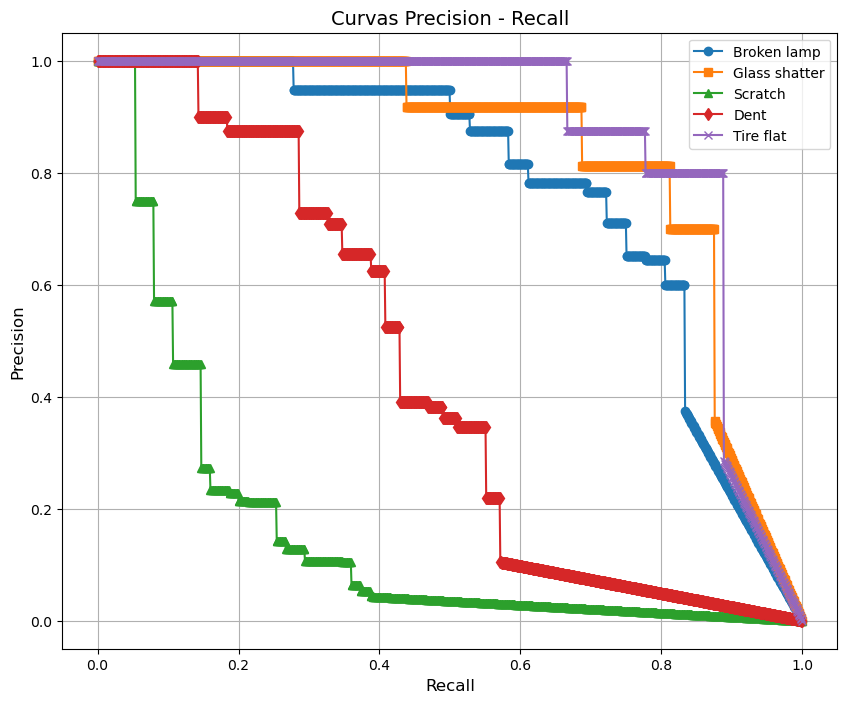

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 0
try:
    x_values = curves_results[n][0]
    y_values_1 = curves_results[n][1][0]
    y_values_2 = curves_results[n][1][1]
    y_values_3 = curves_results[n][1][2]
    y_values_4 = curves_results[n][1][3]
    y_values_5 = curves_results[n][1][4]
except (IndexError, TypeError):
    raise ValueError("El formato de 'curves_results' no es el esperado.")

plt.figure(figsize=(10, 8))

plt.plot(x_values, y_values_1, marker='o', label='Broken lamp')
plt.plot(x_values, y_values_2, marker='s', label='Glass shatter')
plt.plot(x_values, y_values_3, marker='^', label='Scratch')
plt.plot(x_values, y_values_4, marker='d', label='Dent')
plt.plot(x_values, y_values_5, marker='x', label='Tire flat')

try:
    plt.xlabel(curves_results[n][2], fontsize=12)
    plt.ylabel(curves_results[n][3], fontsize=12)
except IndexError:
    plt.xlabel('Eje X', fontsize=12)
    plt.ylabel('Eje Y', fontsize=12)

plt.title('Curvas ' + curves_results[n][3] + ' - ' + curves_results[n][2], fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

A continuación, se identifica para cada etiqueta el valor de Recall que hace que la precisión sea 1. Con el siguiente código se grafican estos puntos y se muestran tambien en formato texto.

Curva: Broken lamp
  Precisión: 1.00 (Recall = 0.28)
--------------------------------------------------
Curva: Glass shatter
  Precisión: 1.00 (Recall = 0.44)
--------------------------------------------------
Curva: Scratch
  Precisión: 1.00 (Recall = 0.05)
--------------------------------------------------
Curva: Dent
  Precisión: 1.00 (Recall = 0.14)
--------------------------------------------------
Curva: Tire flat
  Precisión: 1.00 (Recall = 0.67)
--------------------------------------------------


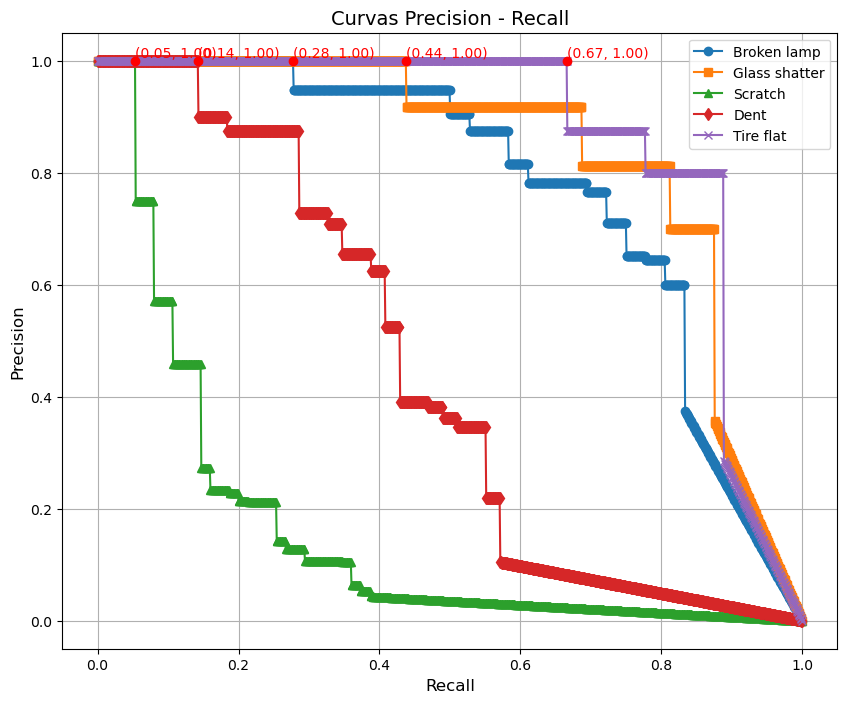

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 0
target_precisions = []
target_recalls = []
try:
    x_values = curves_results[n][0]
    y_values_1 = curves_results[n][1][0]
    y_values_2 = curves_results[n][1][1]
    y_values_3 = curves_results[n][1][2]
    y_values_4 = curves_results[n][1][3]
    y_values_5 = curves_results[n][1][4]
except (IndexError, TypeError):
    raise ValueError("El formato de 'curves_results' no es el esperado.")

# Lista de curvas y etiquetas
curves = [y_values_1, y_values_2, y_values_3, y_values_4, y_values_5]
labels = ['Broken lamp', 'Glass shatter', 'Scratch', 'Dent', 'Tire flat']
markers = ['o', 's', '^', 'd', 'x']

plt.figure(figsize=(10, 8))

for i, (y_values, label, marker) in enumerate(zip(curves, labels, markers)):
    plt.plot(x_values, y_values, marker=marker, label=label)
    
    filtered_indices = [j for j in range(len(x_values)) if x_values[j] > 0]
    filtered_x = [x_values[j] for j in filtered_indices]
    filtered_y = [y_values[j] for j in filtered_indices]
    
    if not filtered_indices:
        continue
    
    precision_1_indices = [i for i in range(len(filtered_y)) if abs(filtered_y[i] - 1) <= 0.01]
    
    if precision_1_indices:
        closest_index = max(precision_1_indices, key=lambda i: filtered_x[i])
    else:
        target_precision = 1  # Buscar precisión más cercana a 1
        closest_index = max(
            [i for i in range(len(filtered_y)) if abs(filtered_y[i] - target_precision) <= 0.1], 
            key=lambda i: filtered_x[i]
        )
    
    highlight_x = filtered_x[closest_index]
    highlight_y = filtered_y[closest_index]
    
    plt.scatter(highlight_x, highlight_y, color='red', zorder=5)
    plt.text(highlight_x, highlight_y, f"({highlight_x:.2f}, {highlight_y:.2f})", 
             fontsize=10, color='red', ha='left', va='bottom')

    target_precisions.append(highlight_y)
    target_recalls.append(highlight_x)
    
    print(f"Curva: {label}")
    print(f"  Precisión: {highlight_y:.2f} (Recall = {highlight_x:.2f})")
    print("-" * 50)

try:
    plt.xlabel(curves_results[n][2], fontsize=12)
    plt.ylabel(curves_results[n][3], fontsize=12)
except IndexError:
    plt.xlabel('Eje X', fontsize=12)
    plt.ylabel('Eje Y', fontsize=12)

plt.title('Curvas ' + curves_results[n][3] + ' - ' + curves_results[n][2], fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

Como era de esperar vistos los resultados obtenidos en la validacion en este modelo, se observan valores de recall bastante bajos, especialmente para algunas etiquetas específicas como Broken lamp, Scratch y Dent, que son las que obtuvieron los peores resultados durante la validación (consultar la documentación escrita).

Una vez obtenido los valores de precisión y recall, se obtiene el valor de confianza. Se puede obtener a partir de la gráfica Precisión - Confianza o bién a través de la Recall - Confianza.

### Curva Precisión-Confianza:

En este apartado, se obtiene el valor de confianza a partir de la Curva Presión - Confianza:

Broken lamp: Conf = 0.94 (para Precision = 1.0)
Glass shatter: Conf = 0.88 (para Precision = 1.0)
Scratch: Conf = 0.88 (para Precision = 1.0)
Dent: Conf = 0.81 (para Precision = 1.0)
Tire flat: Conf = 0.95 (para Precision = 1.0)


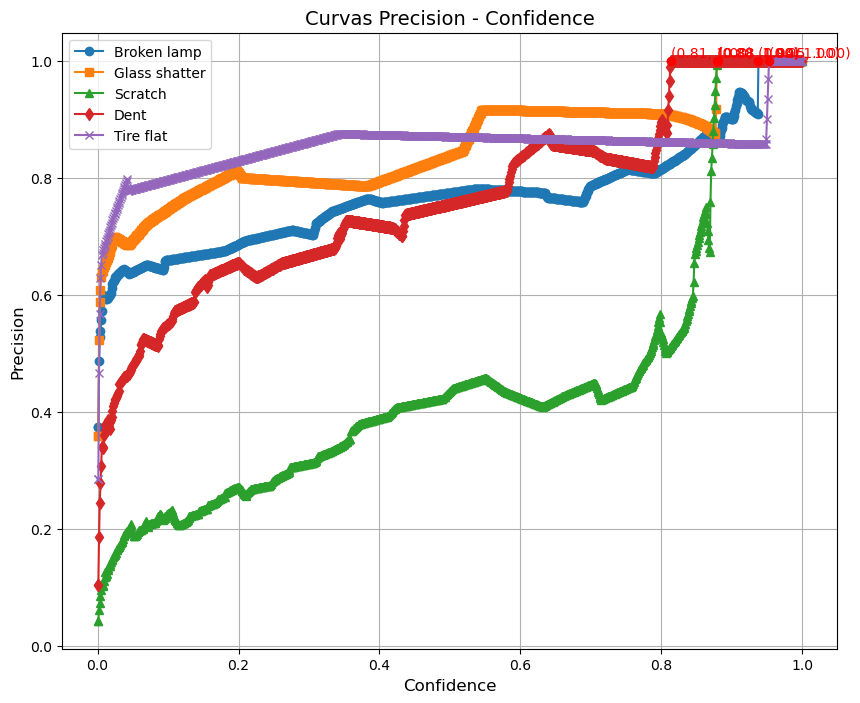

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
conf_array = []
n = 2
try:
    x_values = curves_results[n][0]
    y_values_1 = curves_results[n][1][0]
    y_values_2 = curves_results[n][1][1]
    y_values_3 = curves_results[n][1][2]
    y_values_4 = curves_results[n][1][3]
    y_values_5 = curves_results[n][1][4]
except (IndexError, TypeError):
    raise ValueError("El formato de 'curves_results' no es el esperado.")

curves = [y_values_1, y_values_2, y_values_3, y_values_4, y_values_5]
labels = ['Broken lamp', 'Glass shatter', 'Scratch', 'Dent', 'Tire flat']
markers = ['o', 's', '^', 'd', 'x']

plt.figure(figsize=(10, 8))

for curve, label, marker in zip(curves, labels, markers):
    plt.plot(x_values, curve, marker=marker, label=label)

def find_closest_point(curve, target_precision):
    closest_index = min(range(len(curve)), key=lambda i: abs(curve[i] - target_precision))
    return closest_index

for curve, label, target_precision in zip(curves, labels, target_precisions):
    closest_index = find_closest_point(curve, target_precision)
    highlight_x = x_values[closest_index]
    highlight_y = curve[closest_index]

    conf_array.append(round(highlight_x, 2))
    print(f"{label}: Conf = {round(highlight_x, 2)} (para Precision = {round(target_precision, 2)})")

    plt.scatter(highlight_x, highlight_y, color='red', zorder=5)
    plt.text(highlight_x, highlight_y, f"({highlight_x:.2f}, {highlight_y:.2f})", 
             fontsize=10, color='red', ha='left', va='bottom')

try:
    plt.xlabel(curves_results[n][2], fontsize=12)
    plt.ylabel(curves_results[n][3], fontsize=12)
except IndexError:
    plt.xlabel('Eje X', fontsize=12)
    plt.ylabel('Eje Y', fontsize=12)

plt.title('Curvas ' + curves_results[n][3] + ' - ' + curves_results[n][2], fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

### Curva Recall-Conf

En este apartado, se obtiene el valor de confianza a partir de la Curva Recall - Confianza:

Broken lamp: Conf = 0.94 (para Recall = 0.28)
Glass shatter: Conf = 0.88 (para Recall = 0.44)
Scratch: Conf = 0.88 (para Recall = 0.05)
Dent: Conf = 0.81 (para Recall = 0.14)
Tire flat: Conf = 0.95 (para Recall = 0.67)


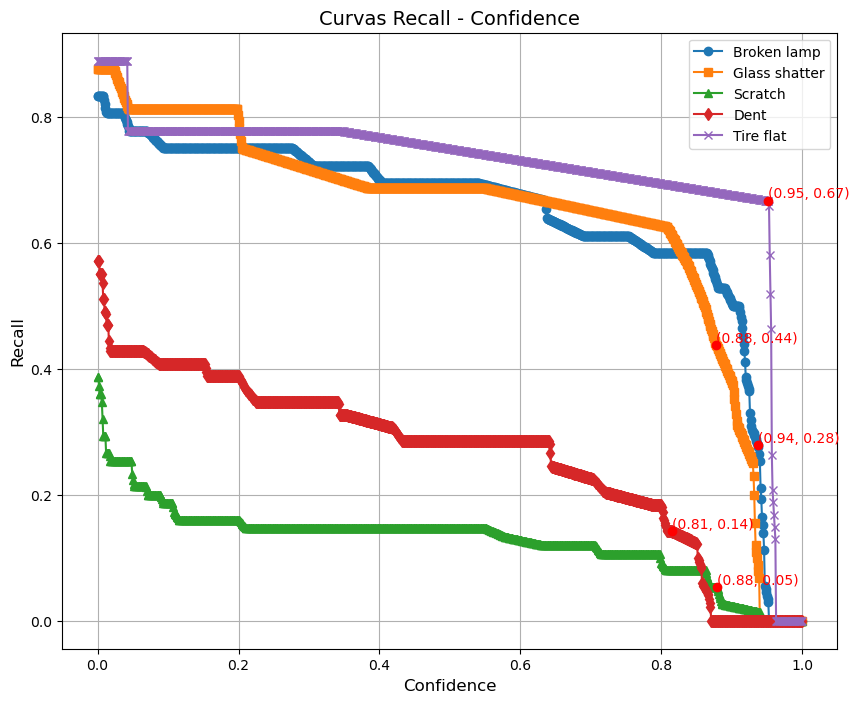

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
conf_array = []
n = 3
try:
    x_values = curves_results[n][0]
    y_values_1 = curves_results[n][1][0]
    y_values_2 = curves_results[n][1][1]
    y_values_3 = curves_results[n][1][2]
    y_values_4 = curves_results[n][1][3]
    y_values_5 = curves_results[n][1][4]
except (IndexError, TypeError):
    raise ValueError("El formato de 'curves_results' no es el esperado.")

curves = [y_values_1, y_values_2, y_values_3, y_values_4, y_values_5]
labels = ['Broken lamp', 'Glass shatter', 'Scratch', 'Dent', 'Tire flat']
markers = ['o', 's', '^', 'd', 'x']

plt.figure(figsize=(10, 8))

for curve, label, marker in zip(curves, labels, markers):
    plt.plot(x_values, curve, marker=marker, label=label)

def find_closest_point(curve, target_recalls):
    min_diff = float('inf')
    best_index = -1

    for i, val in enumerate(curve):
        diff = abs(val - target_recalls)
        if diff < min_diff:
            min_diff = diff
            best_index = i
        elif diff == min_diff:
            if x_values[i] > x_values[best_index]:
                best_index = i

    return best_index

for curve, label, target_recalls in zip(curves, labels, target_recalls):
    closest_index = find_closest_point(curve, target_recalls)
    highlight_x = x_values[closest_index]
    highlight_y = curve[closest_index]

    # Imprimir el punto
    conf_array.append(round(highlight_x, 2))
    print(f"{label}: Conf = {round(highlight_x, 2)} (para Recall = {round(target_recalls, 2)})")

    plt.scatter(highlight_x, highlight_y, color='red', zorder=5)
    plt.text(highlight_x, highlight_y, f"({highlight_x:.2f}, {highlight_y:.2f})", 
             fontsize=10, color='red', ha='left', va='bottom')

try:
    plt.xlabel(curves_results[n][2], fontsize=12)
    plt.ylabel(curves_results[n][3], fontsize=12)
except IndexError:
    plt.xlabel('Eje X', fontsize=12)
    plt.ylabel('Eje Y', fontsize=12)

plt.title('Curvas ' + curves_results[n][3] + ' - ' + curves_results[n][2], fontsize=14)
plt.legend()
plt.grid(True)

plt.show()


Como se puede observar, se obtienen los mismos valores de Confianza de ambas formas.

### Conclusión

Finalmente, se obtienen los siguientes valores de confianza:

- Broken lamp: 0.94
- Glass shatter: 0.88
- Scratch: 0.88
- Dent: 0.81
- Tire flat: 0.95

Estos valores son bastante altos, lo que implica que el modelo únicamente generará un resultado cuando tenga un alto grado de certeza (alta precisión). Sin embargo, también significa que muchas predicciones serán omitidas, ya que el modelo optará por no arriesgarse, lo que resultará en un bajo recall.

Estos valores de confianza para cada etiqueta serían adecuados si este fuera el modelo definitivo. Sin embargo, dado que se implementará un sistema que permita el reentrenamiento del modelo a partir de los errores reportados por el usuario, es necesario que inicialmente el modelo tenga un recall más alto y una precisión más baja. Esto permitirá que el modelo genere más predicciones erróneas y así el usuario pueda reportar los fallos. De este modo, se podrán recopilar datos más representativos y ajustados a las imágenes reales que el usuario proporciona, lo que permitirá mejorar significativamente el rendimiento del modelo en futuras iteraciones.

Por lo tanto, en el siguiente Notebook se modificará este valor de confianza aplicandole un factor multiplicado (entre 0 y 1). 